<a href="https://www.kaggle.com/code/pierremonroy/september-tabular-playground-eda-sarima?scriptVersionId=106390577" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install darts
!pip install kats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.1/424.1 kB 688.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.5/612.5 kB 849.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.3/950.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 19.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import seaborn as sns
from itertools import product

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow import keras

from darts import TimeSeries
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import RBF

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [3]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [4]:
train = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

In [5]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## EDA

We basically have 4 dimensions under which we need to explore the data:
* time
* country
* store
* product

Given the categorical nature of the data, the most obvious would be to have a time series plot of each product's sales for each location (country + store) so 12 plots in total with 4 lines on each.

In [6]:
train

row_id       date  country       store  \
0           0 2017-01-01  Belgium  KaggleMart   
1           1 2017-01-01  Belgium  KaggleMart   
2           2 2017-01-01  Belgium  KaggleMart   
3           3 2017-01-01  Belgium  KaggleMart   
4           4 2017-01-01  Belgium  KaggleRama   
...       ...        ...      ...         ...   
70123   70123 2020-12-31    Spain  KaggleMart   
70124   70124 2020-12-31    Spain  KaggleRama   
70125   70125 2020-12-31    Spain  KaggleRama   
70126   70126 2020-12-31    Spain  KaggleRama   
70127   70127 2020-12-31    Spain  KaggleRama   

                                product  num_sold  
0            Kaggle Advanced Techniques       663  
1                Kaggle Getting Started       615  
2                    Kaggle Recipe Book       480  
3      Kaggle for Kids: One Smart Goose       710  
4            Kaggle Advanced Techniques       240  
...                                 ...       ...  
70123  Kaggle for Kids: One Smart Goose       614  
70124        Kaggle Advanced Techniques       215  
70125            Kaggle Getting Started       158  
70126                Kaggle Recipe Book       135  
70127  Kaggle for Kids: One Smart Goose       202  

[70128 rows x 6 columns]

In [7]:
train.describe()

row_id      num_sold
count  70128.000000  70128.000000
mean   35063.500000    194.296986
std    20244.354176    126.893874
min        0.000000     19.000000
25%    17531.750000     95.000000
50%    35063.500000    148.000000
75%    52595.250000    283.000000
max    70127.000000    986.000000

In [8]:
test.describe()

row_id
count  17520.000000
mean   78887.500000
std     5057.732694
min    70128.000000
25%    74507.750000
50%    78887.500000
75%    83267.250000
max    87647.000000

In [9]:
test.head()

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

#### Checking if any NA

In [10]:
train.isna().sum()

row_id      0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [11]:
test.isna().sum()

row_id     0
date       0
country    0
store      0
product    0
dtype: int64

#### Checking categorical unique values in train and test sets

In [12]:
print(train['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [13]:
print(test['product'].unique())

['Kaggle Advanced Techniques' 'Kaggle Getting Started'
 'Kaggle Recipe Book' 'Kaggle for Kids: One Smart Goose']


In [14]:
print(train['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [15]:
print(test['country'].unique())

['Belgium' 'France' 'Germany' 'Italy' 'Poland' 'Spain']


In [16]:
print(train['store'].unique())

['KaggleMart' 'KaggleRama']


In [17]:
print(test['store'].unique())

['KaggleMart' 'KaggleRama']


In [18]:
train['product'].unique()

array(['Kaggle Advanced Techniques', 'Kaggle Getting Started',
       'Kaggle Recipe Book', 'Kaggle for Kids: One Smart Goose'],
      dtype=object)

#### Simplifying data handling by renaming products

In [19]:
train.loc[train['product']=='Kaggle Advanced Techniques','product'] = 'A'
train.loc[train['product']=='Kaggle Getting Started','product'] = 'B'
train.loc[train['product']=='Kaggle Recipe Book','product'] = 'C'
train.loc[train['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [20]:
test.loc[test['product']=='Kaggle Advanced Techniques','product'] = 'A'
test.loc[test['product']=='Kaggle Getting Started','product'] = 'B'
test.loc[test['product']=='Kaggle Recipe Book','product'] = 'C'
test.loc[test['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [21]:
prods = train['product'].unique()
countries = train['country'].unique()
stores = train['store'].unique()

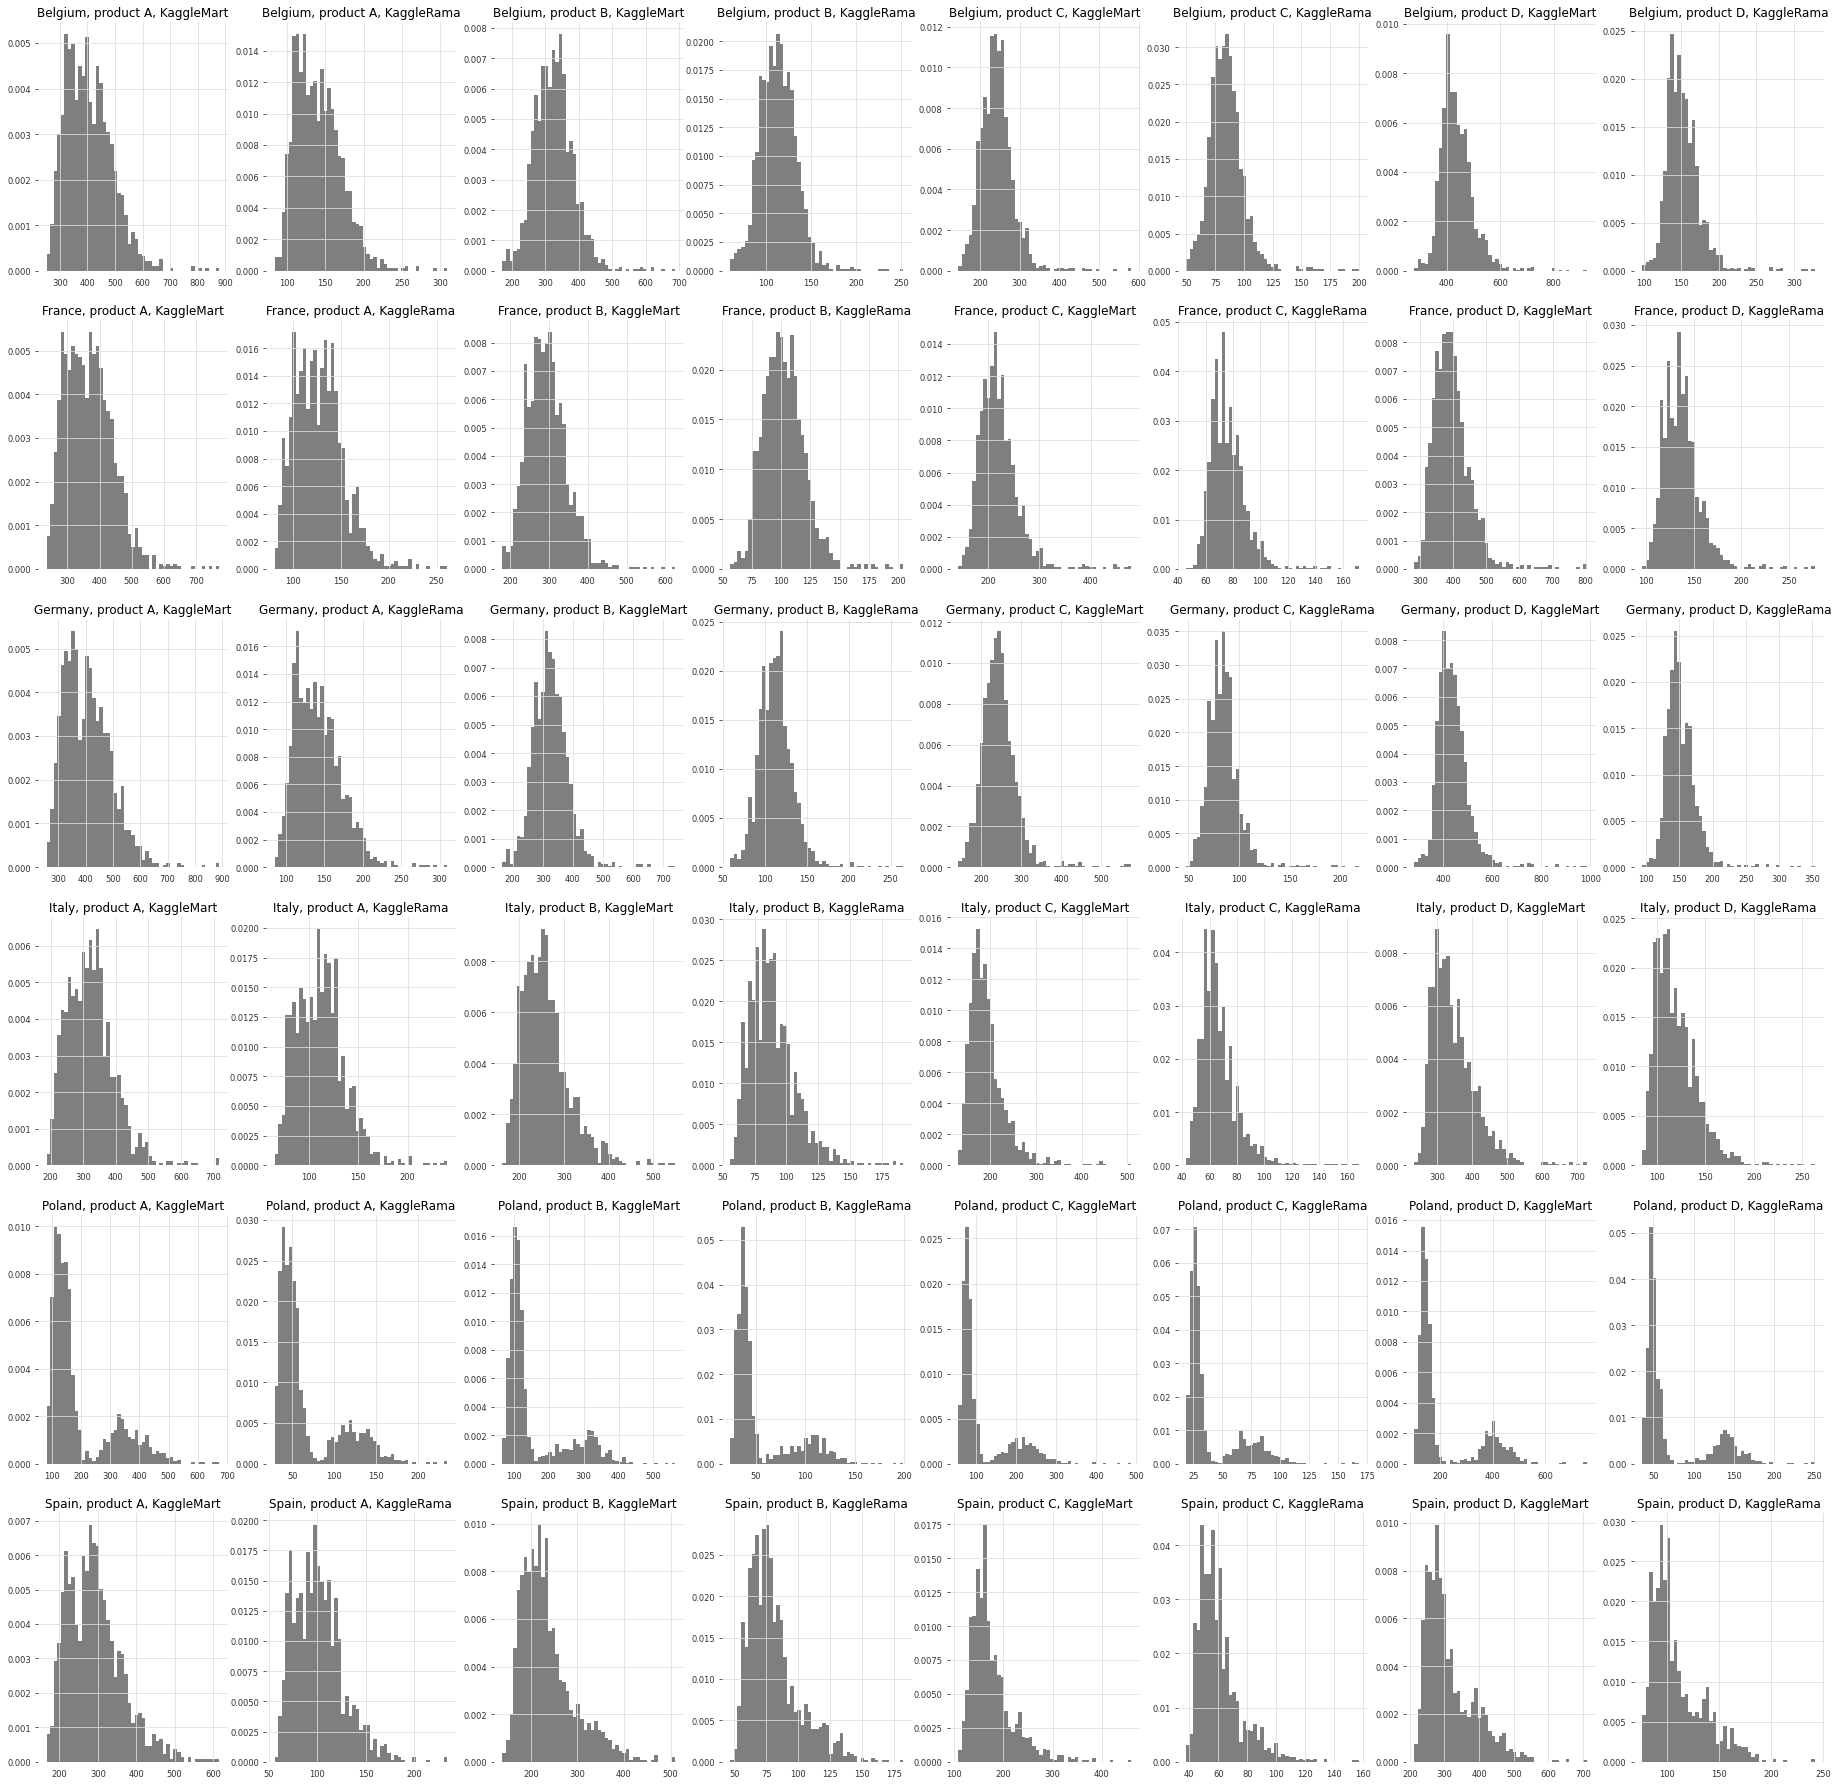

In [22]:
all_combinations = [x for x in product(countries, prods, stores)]

_, axs = plt.subplots(6,8, figsize=(32,32))

for x, ax in zip(all_combinations, axs.ravel()):
    tmp_train = train[(train['country'] == x[0]) & (train['product'] == x[1]) & (train['store'] == x[2])]

    mi = tmp_train['num_sold'].min()
    ma = tmp_train['num_sold'].max()
    bins = np.linspace(mi, ma, 50)
    ax.hist(tmp_train['num_sold'], bins=bins, alpha=0.5, density=True, label='train')
#     ax.set_ylabel(x[0])
    ax.set_title('{c}, product {p}, {s}'.format(c=x[0], p=x[1], s=x[2]))
    
plt.show()

In [23]:
train.dtypes

row_id               int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold             int64
dtype: object

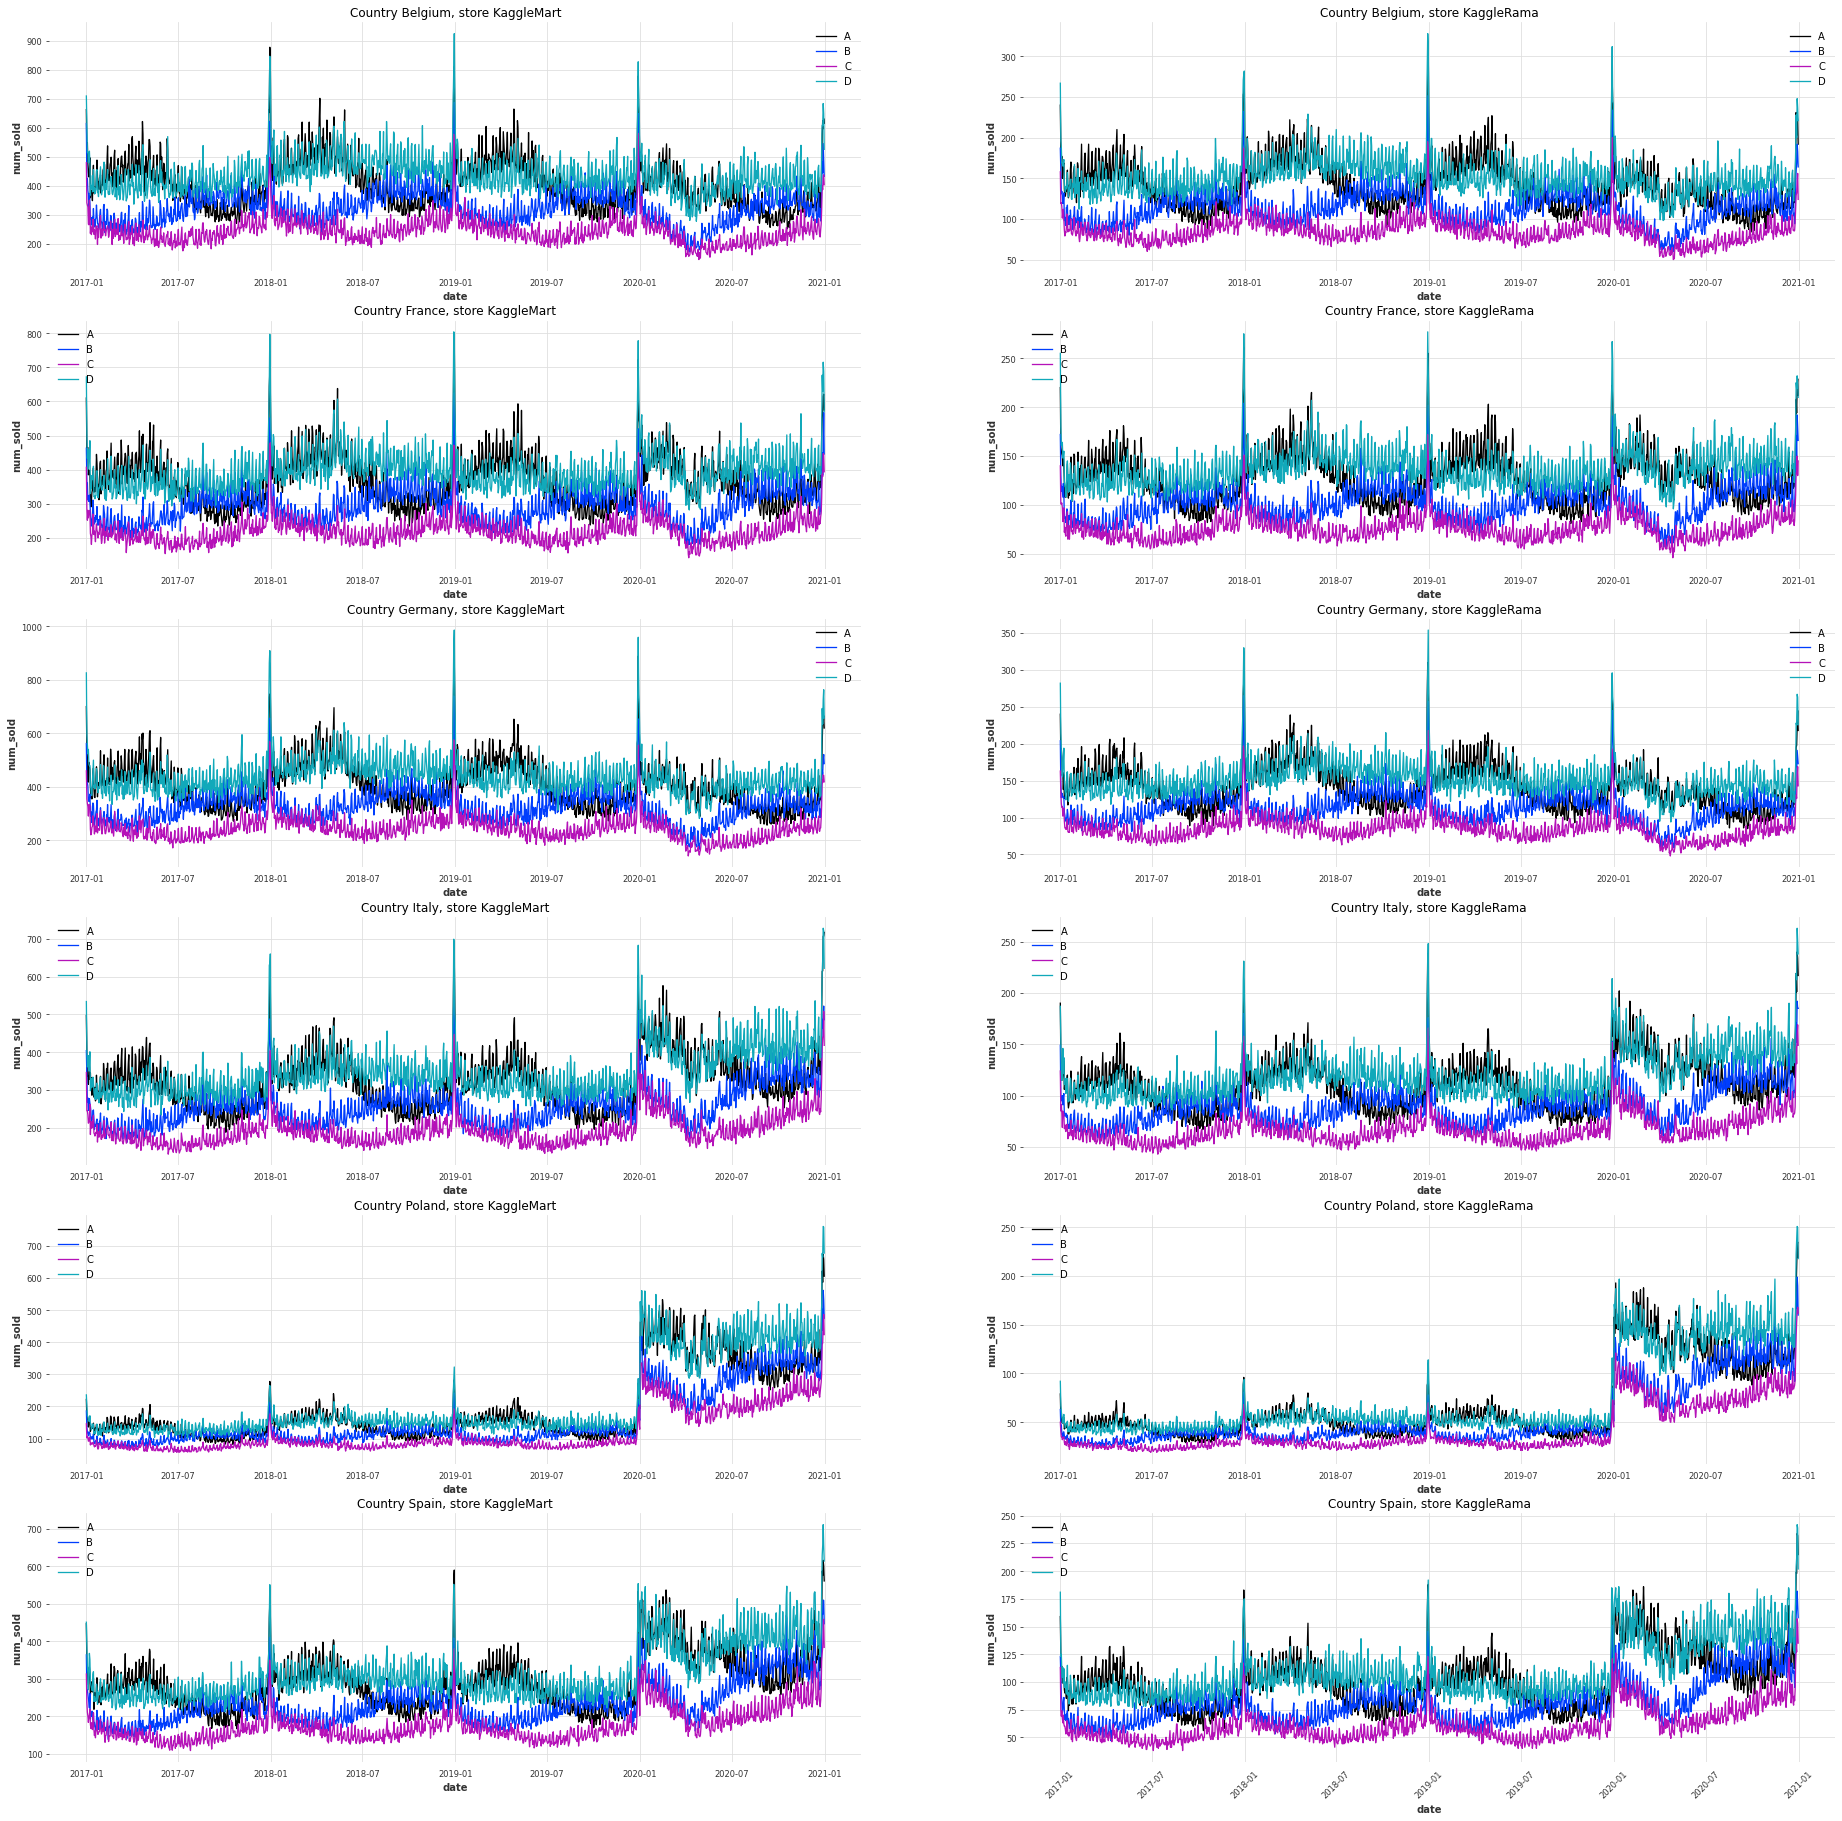

In [24]:
_, axs = plt.subplots(6,2, figsize=(32,32))

for x, ax in zip([x for x in product(countries, stores)], axs.ravel()):

    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'A') & (train['store'] == x[1]) & (train['country'] == x[0])], label="A",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'B') & (train['store'] == x[1]) & (train['country'] == x[0])], label="B",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'C') & (train['store'] == x[1]) & (train['country'] == x[0])], label="C",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'D') & (train['store'] == x[1]) & (train['country'] == x[0])], label="D",ax=ax)
    ax.set_title('Country {c}, store {s}'.format(c=x[0], s=x[1]))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

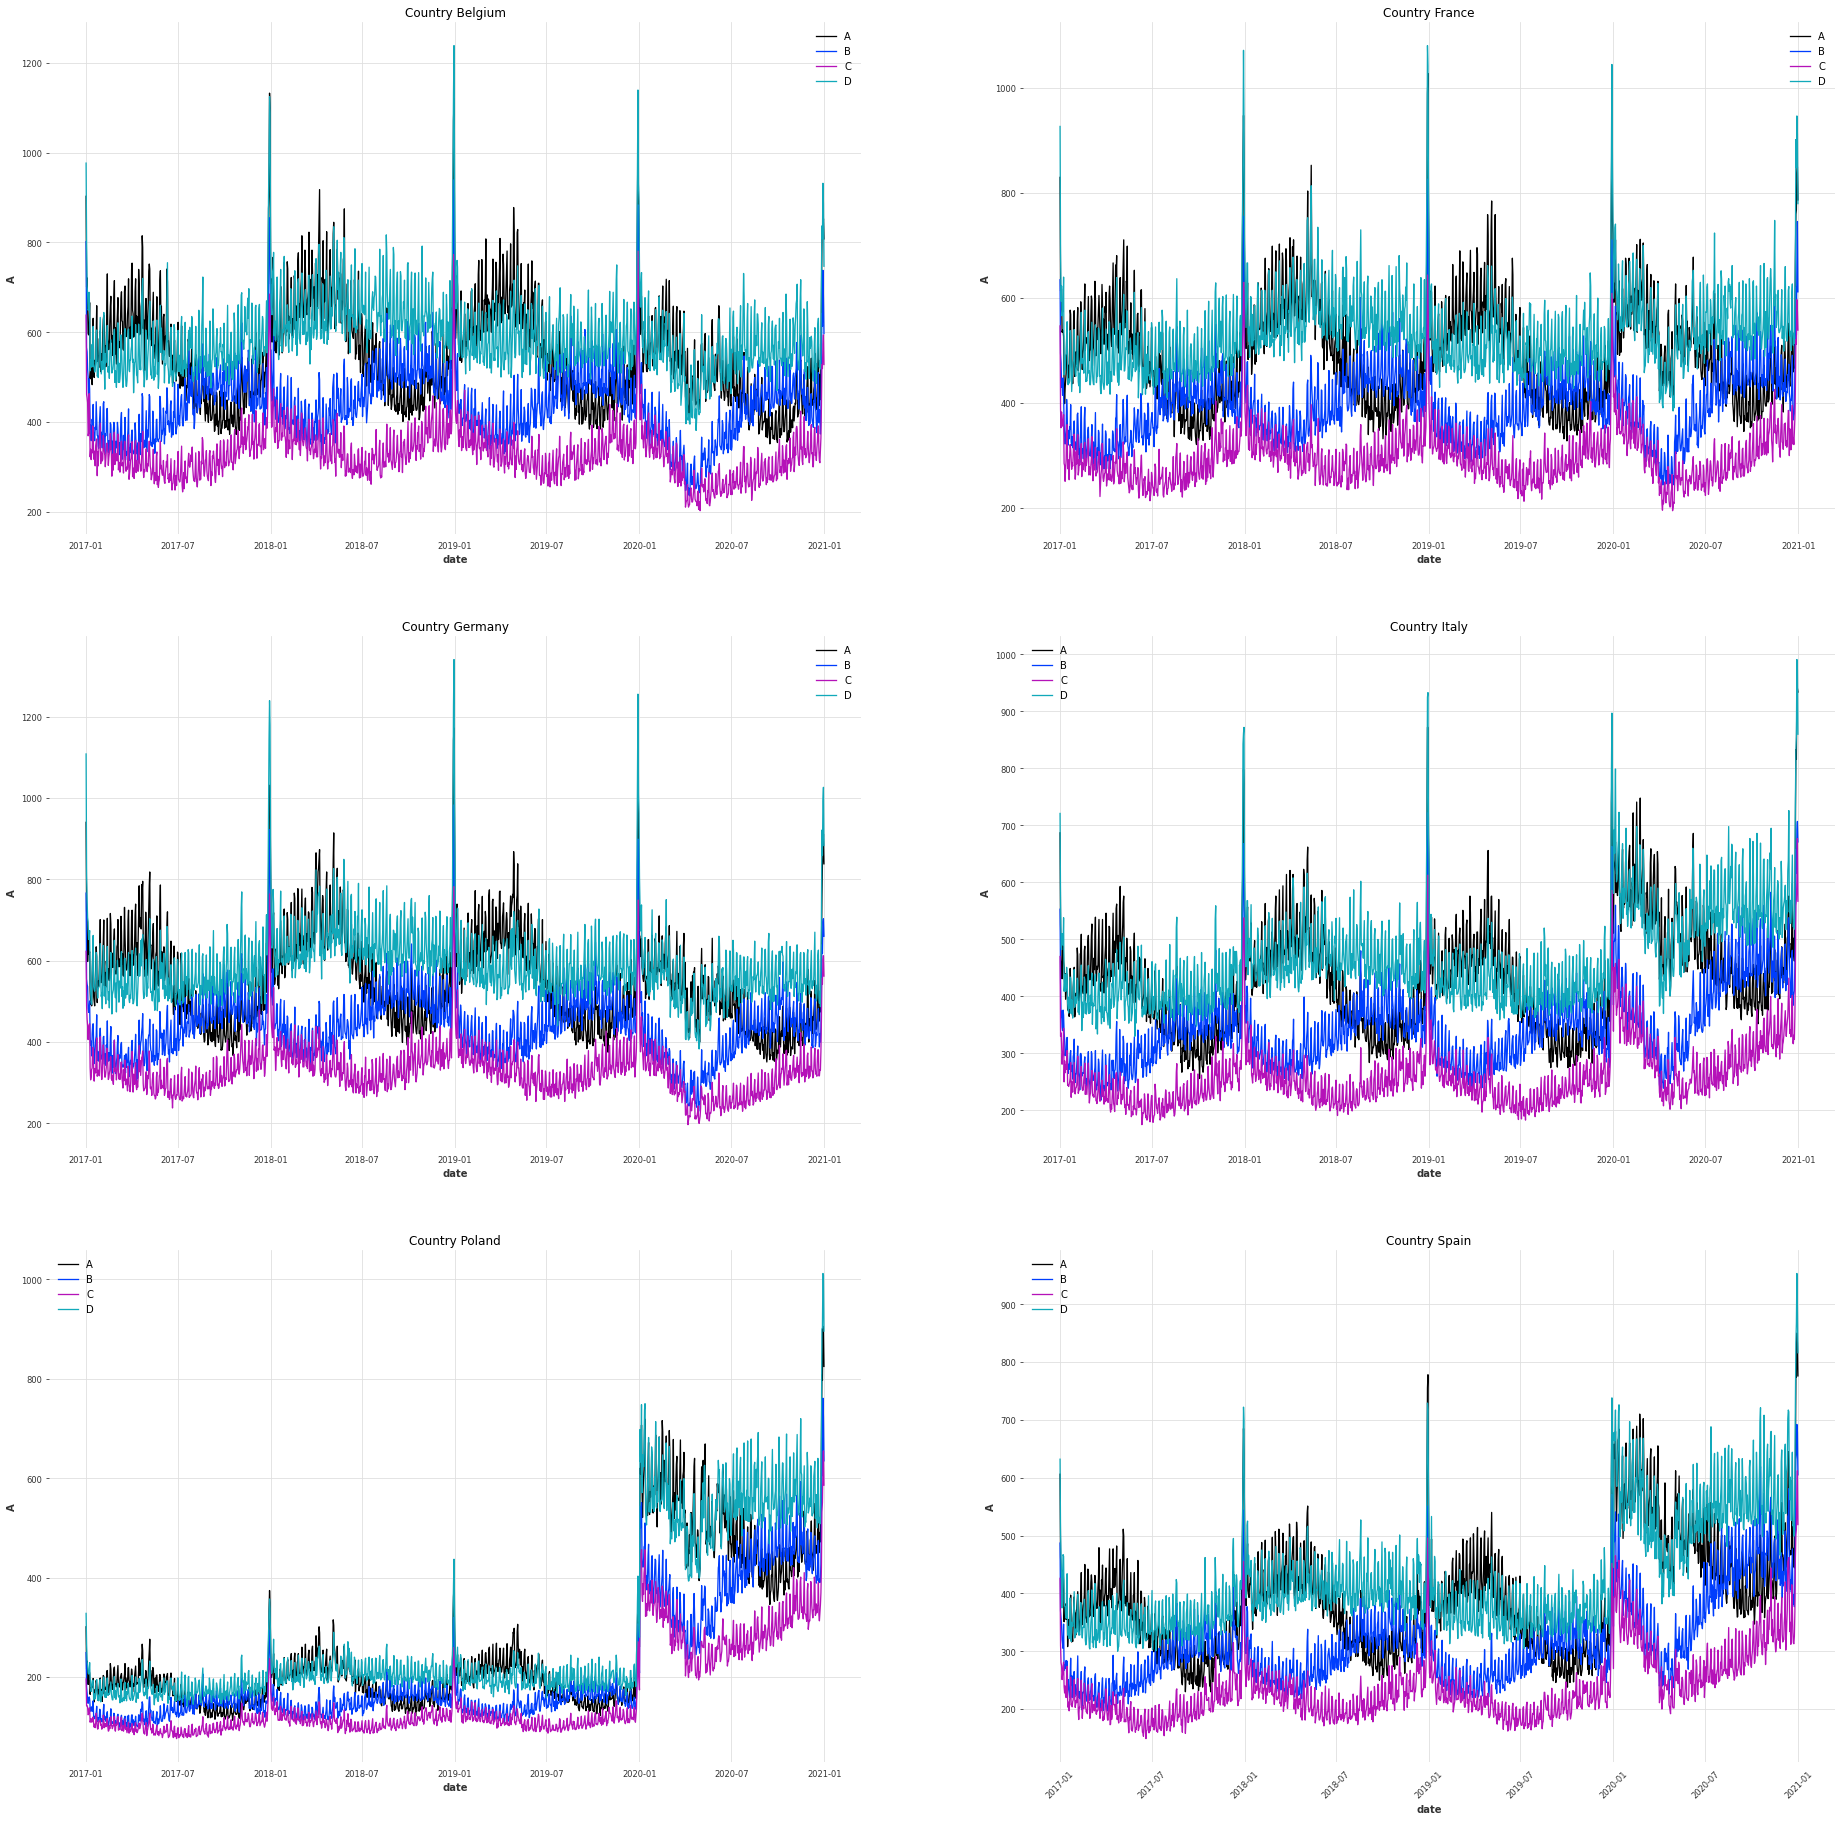

In [25]:
_, axs = plt.subplots(3,2, figsize=(32,32))

for x, ax in zip(countries, axs.ravel()):
    tmp_df = train[train['country'] == x].groupby(['date','product']).sum().unstack(1)
    sns.lineplot(x='date', y='A', data=tmp_df['num_sold'], label="A",ax=ax)
    sns.lineplot(x='date', y='B', data=tmp_df['num_sold'], label="B",ax=ax)
    sns.lineplot(x='date', y='C', data=tmp_df['num_sold'], label="C",ax=ax)
    sns.lineplot(x='date', y='D', data=tmp_df['num_sold'], label="D",ax=ax)
    ax.set_title('Country {c}'.format(c=x))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

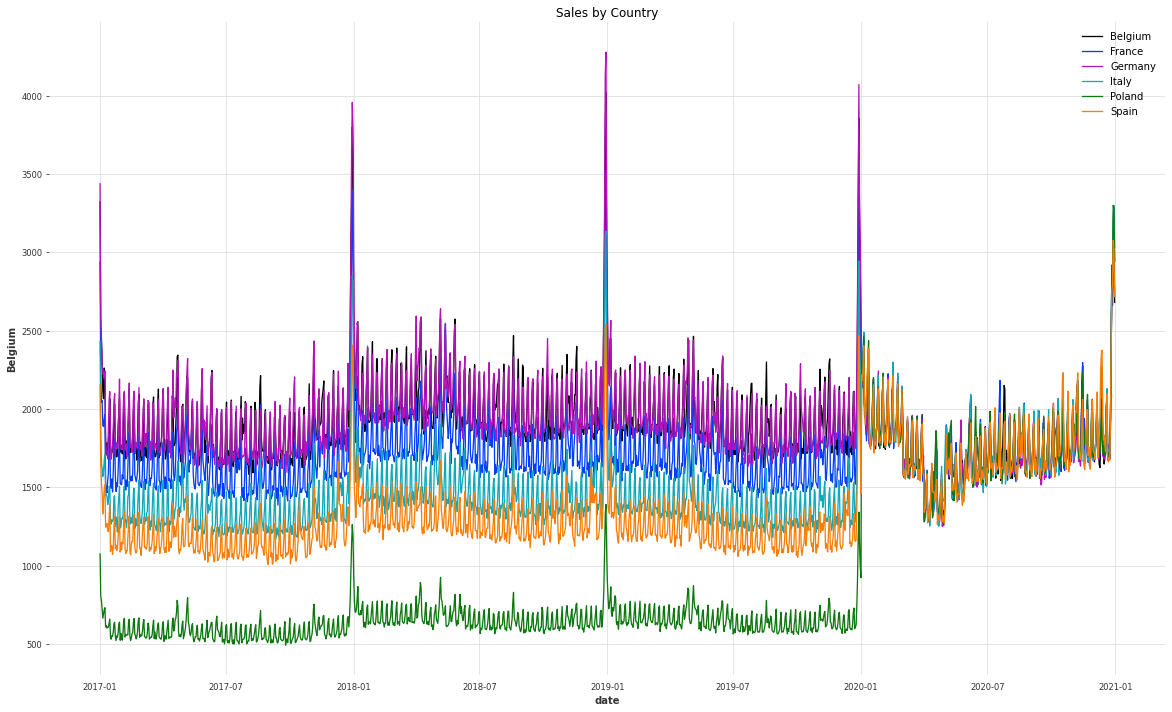

In [26]:
tmp_df = train.groupby(['date','country']).sum().unstack(1)['num_sold']

plt.figure(figsize=(20,12))

for country in countries:
    sns.lineplot(x='date', y=country, data=tmp_df, label=country)

plt.title('Sales by Country')
plt.show()

### Stores Sales Ratio

Reproducing here the store ratio approach by https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach#EDA


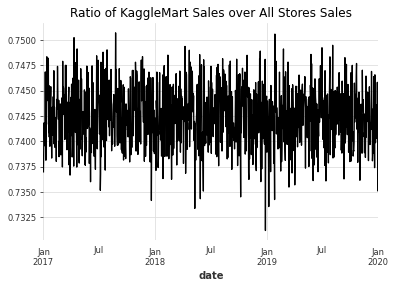

In [27]:
train_gp = train.set_index('date').loc[:'2020-01-01',:].groupby(['date','store']).sum().unstack(1)['num_sold']
train_gp['ratio'] = train_gp['KaggleMart'] / (train_gp['KaggleMart'] + train_gp['KaggleRama'])
train_gp['ratio'].plot()
plt.title('Ratio of KaggleMart Sales over All Stores Sales')
plt.show()

In [28]:
train_gp['ratio']

date
2017-01-01    0.736972
2017-01-02    0.739679
2017-01-03    0.741823
2017-01-04    0.740641
2017-01-05    0.739561
                ...   
2019-12-28    0.740592
2019-12-29    0.745831
2019-12-30    0.739472
2019-12-31    0.735076
2020-01-01    0.744237
Name: ratio, Length: 1096, dtype: float64

In [29]:
train_gp['ratio'].mean()

0.7424903876815521

### Product Sales Ratio by Country

Reproducing here the store ratio approach by https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach#EDA


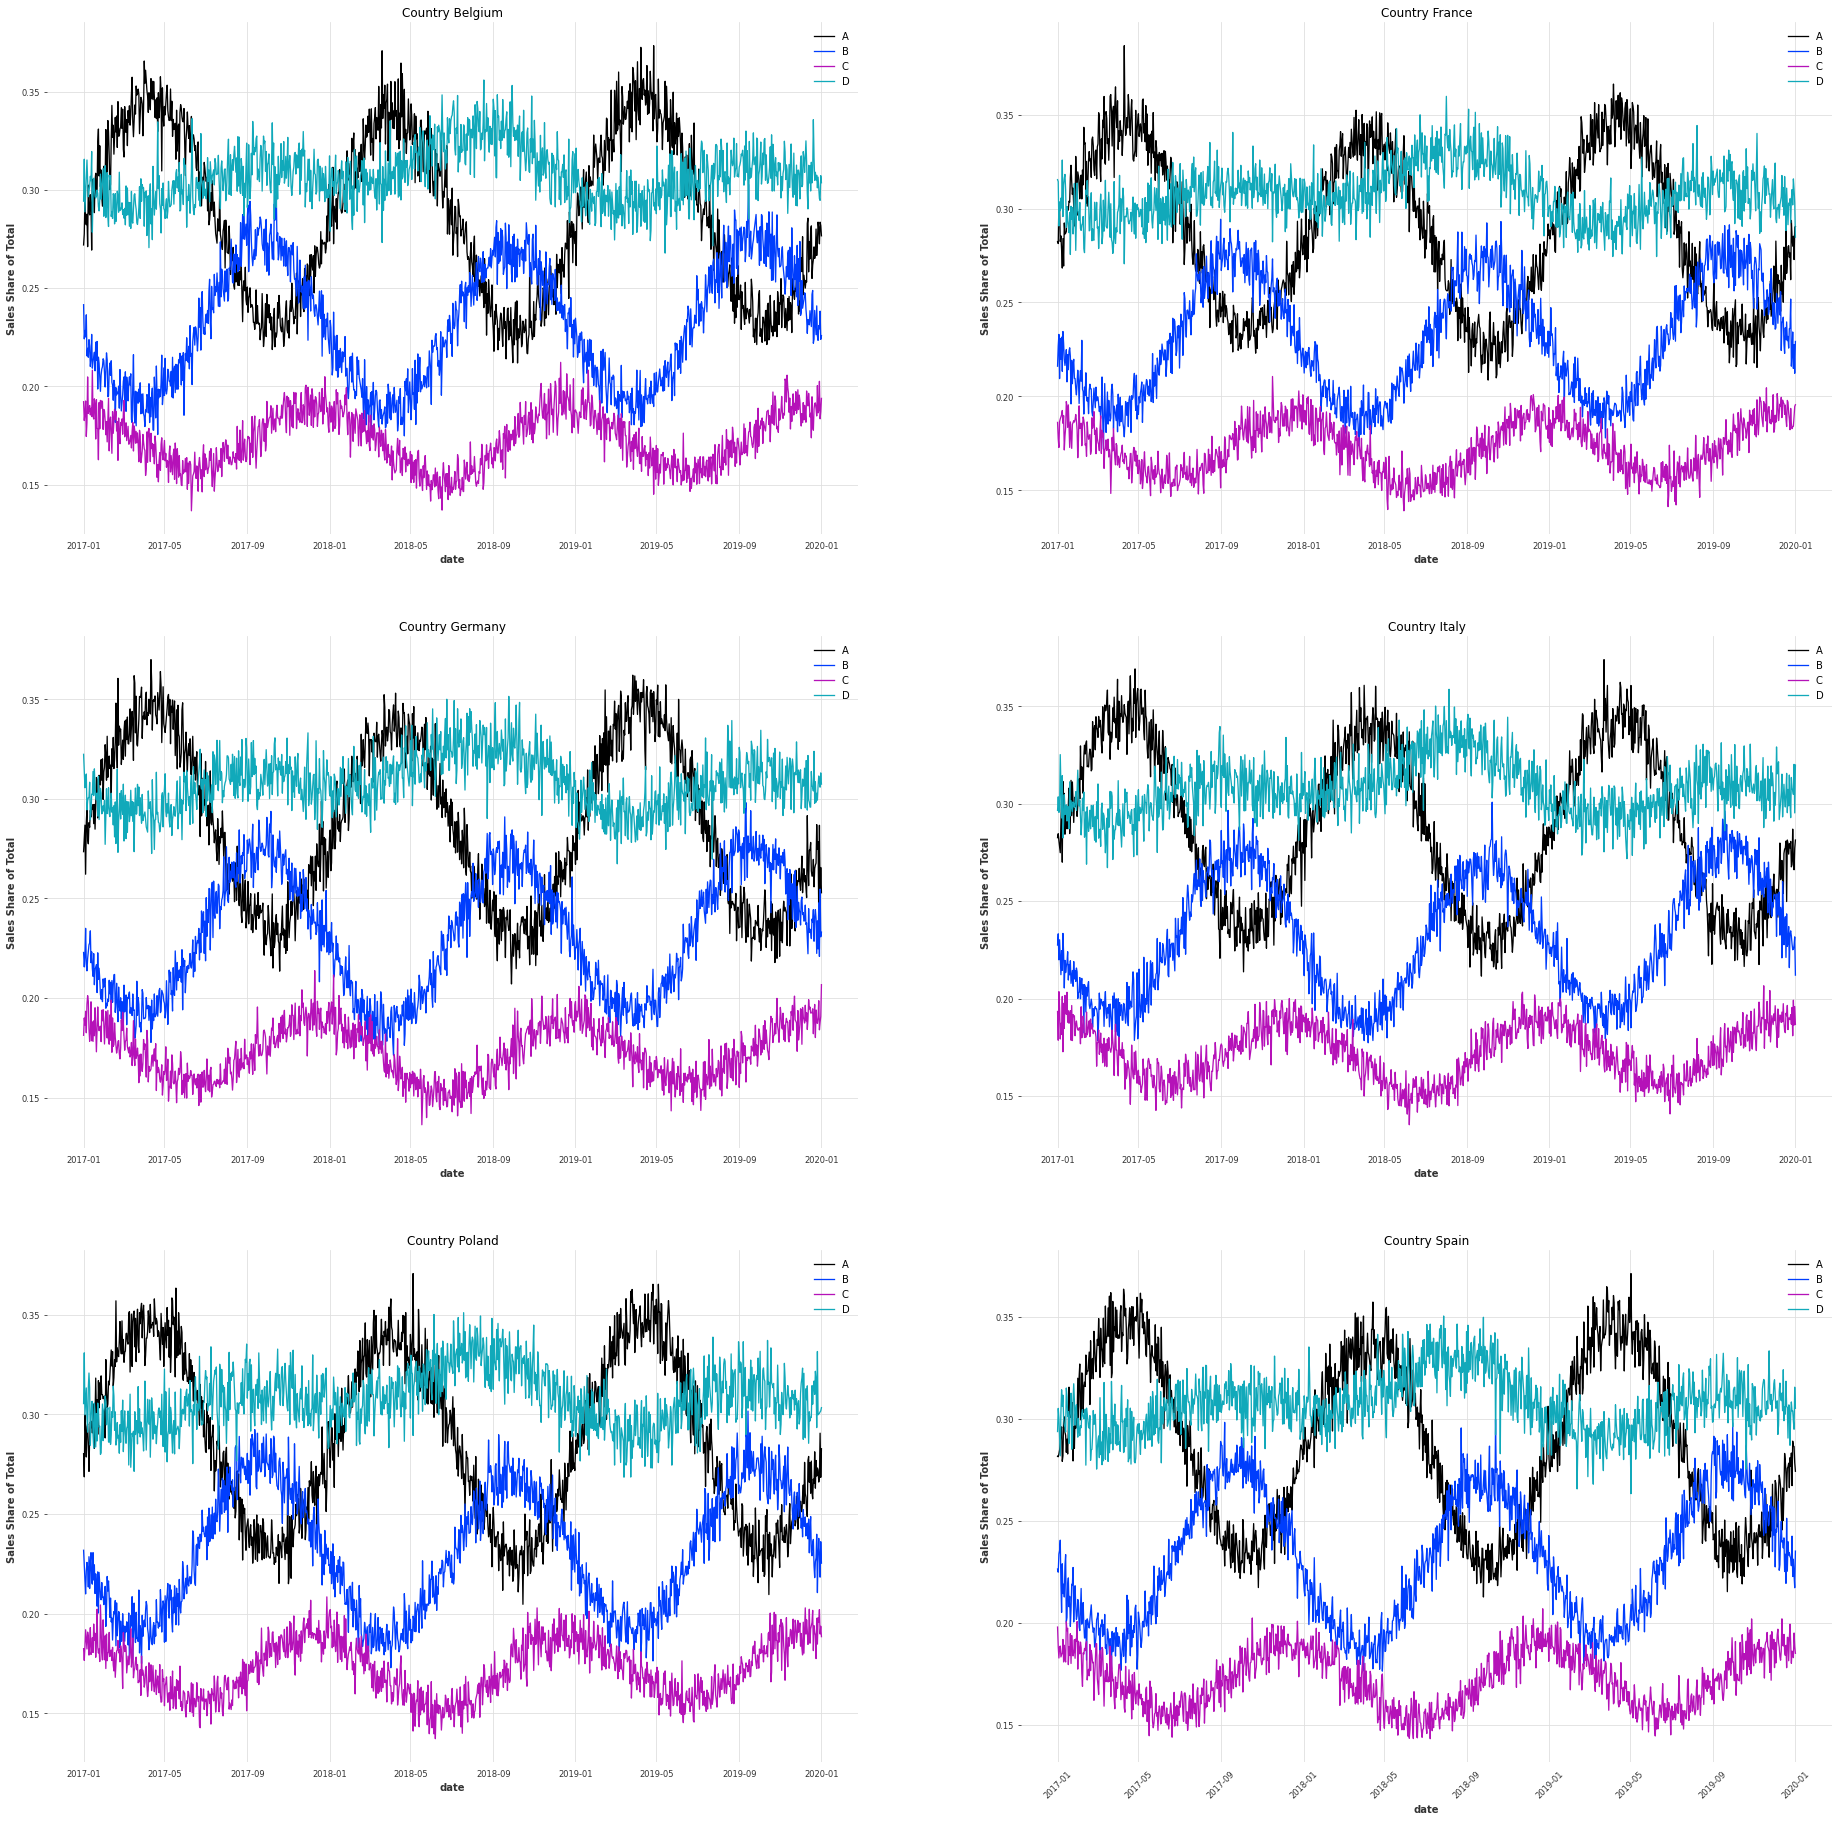

In [30]:
_, axs = plt.subplots(3,2, figsize=(32,32))

for x, ax in zip(countries, axs.ravel()):
    tmp_df = train.set_index('date').loc[:'2020-01-01',:].groupby(['date','country','product']).sum().unstack([1,2])['num_sold'][x]
    tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
    sns.lineplot(x='date', y='A', data=tmp_df, label="A",ax=ax)
    sns.lineplot(x='date', y='B', data=tmp_df, label="B",ax=ax)
    sns.lineplot(x='date', y='C', data=tmp_df, label="C",ax=ax)
    sns.lineplot(x='date', y='D', data=tmp_df, label="D",ax=ax)
    ax.set_title('Country {c}'.format(c=x))
    ax.set_ylabel('Sales Share of Total')
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

In [31]:
# tmp_df = train.set_index('date').loc[:'2020-01-01',:].groupby(['date','country','product']).sum().unstack([1,2])['num_sold']['France']
# tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)

In [32]:
# tmp_df['A']

In [33]:
# fourier = CalendarFourier(freq="2A", order=2)  # 2 sin/cos pairs

# dp = DeterministicProcess(
#     index=tmp_df.index,
#     constant=True,               # dummy feature for bias (y-intercept)
#     order=0,                     # trend (order 1 means linear)
#     seasonal=False,               # weekly seasonality (indicators)
#     additional_terms=[fourier],  # annual seasonality (fourier)
#     drop=True                    # drop terms to avoid collinearity
# )

In [34]:
# X = dp.in_sample()
# X

In [35]:
# ols = sm.OLS(tmp_df['A'], dp.in_sample())
# ols = ols.fit()

In [36]:
# ols.summary()

In [37]:
# pred_ols = ols.predict(X)

In [38]:
# pred_ols

In [39]:
# res = pd.concat([tmp_df['A'], pred_ols],axis=1).rename(columns={'A': 'true_y', 0:'pred_y'})

In [40]:
# res.plot()

### Fourier Transform

Apart from a clear weekly seasonality, which we can model by adding day of the week indicator variables, it's hard to generalize seasonal observation from the periodograms but we could experiment with adding Fourier pairs to model seasonality in a regression.

In [41]:
### Reusing code from Kaggle Course: https://www.kaggle.com/code/ryanholbrook/seasonality

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """


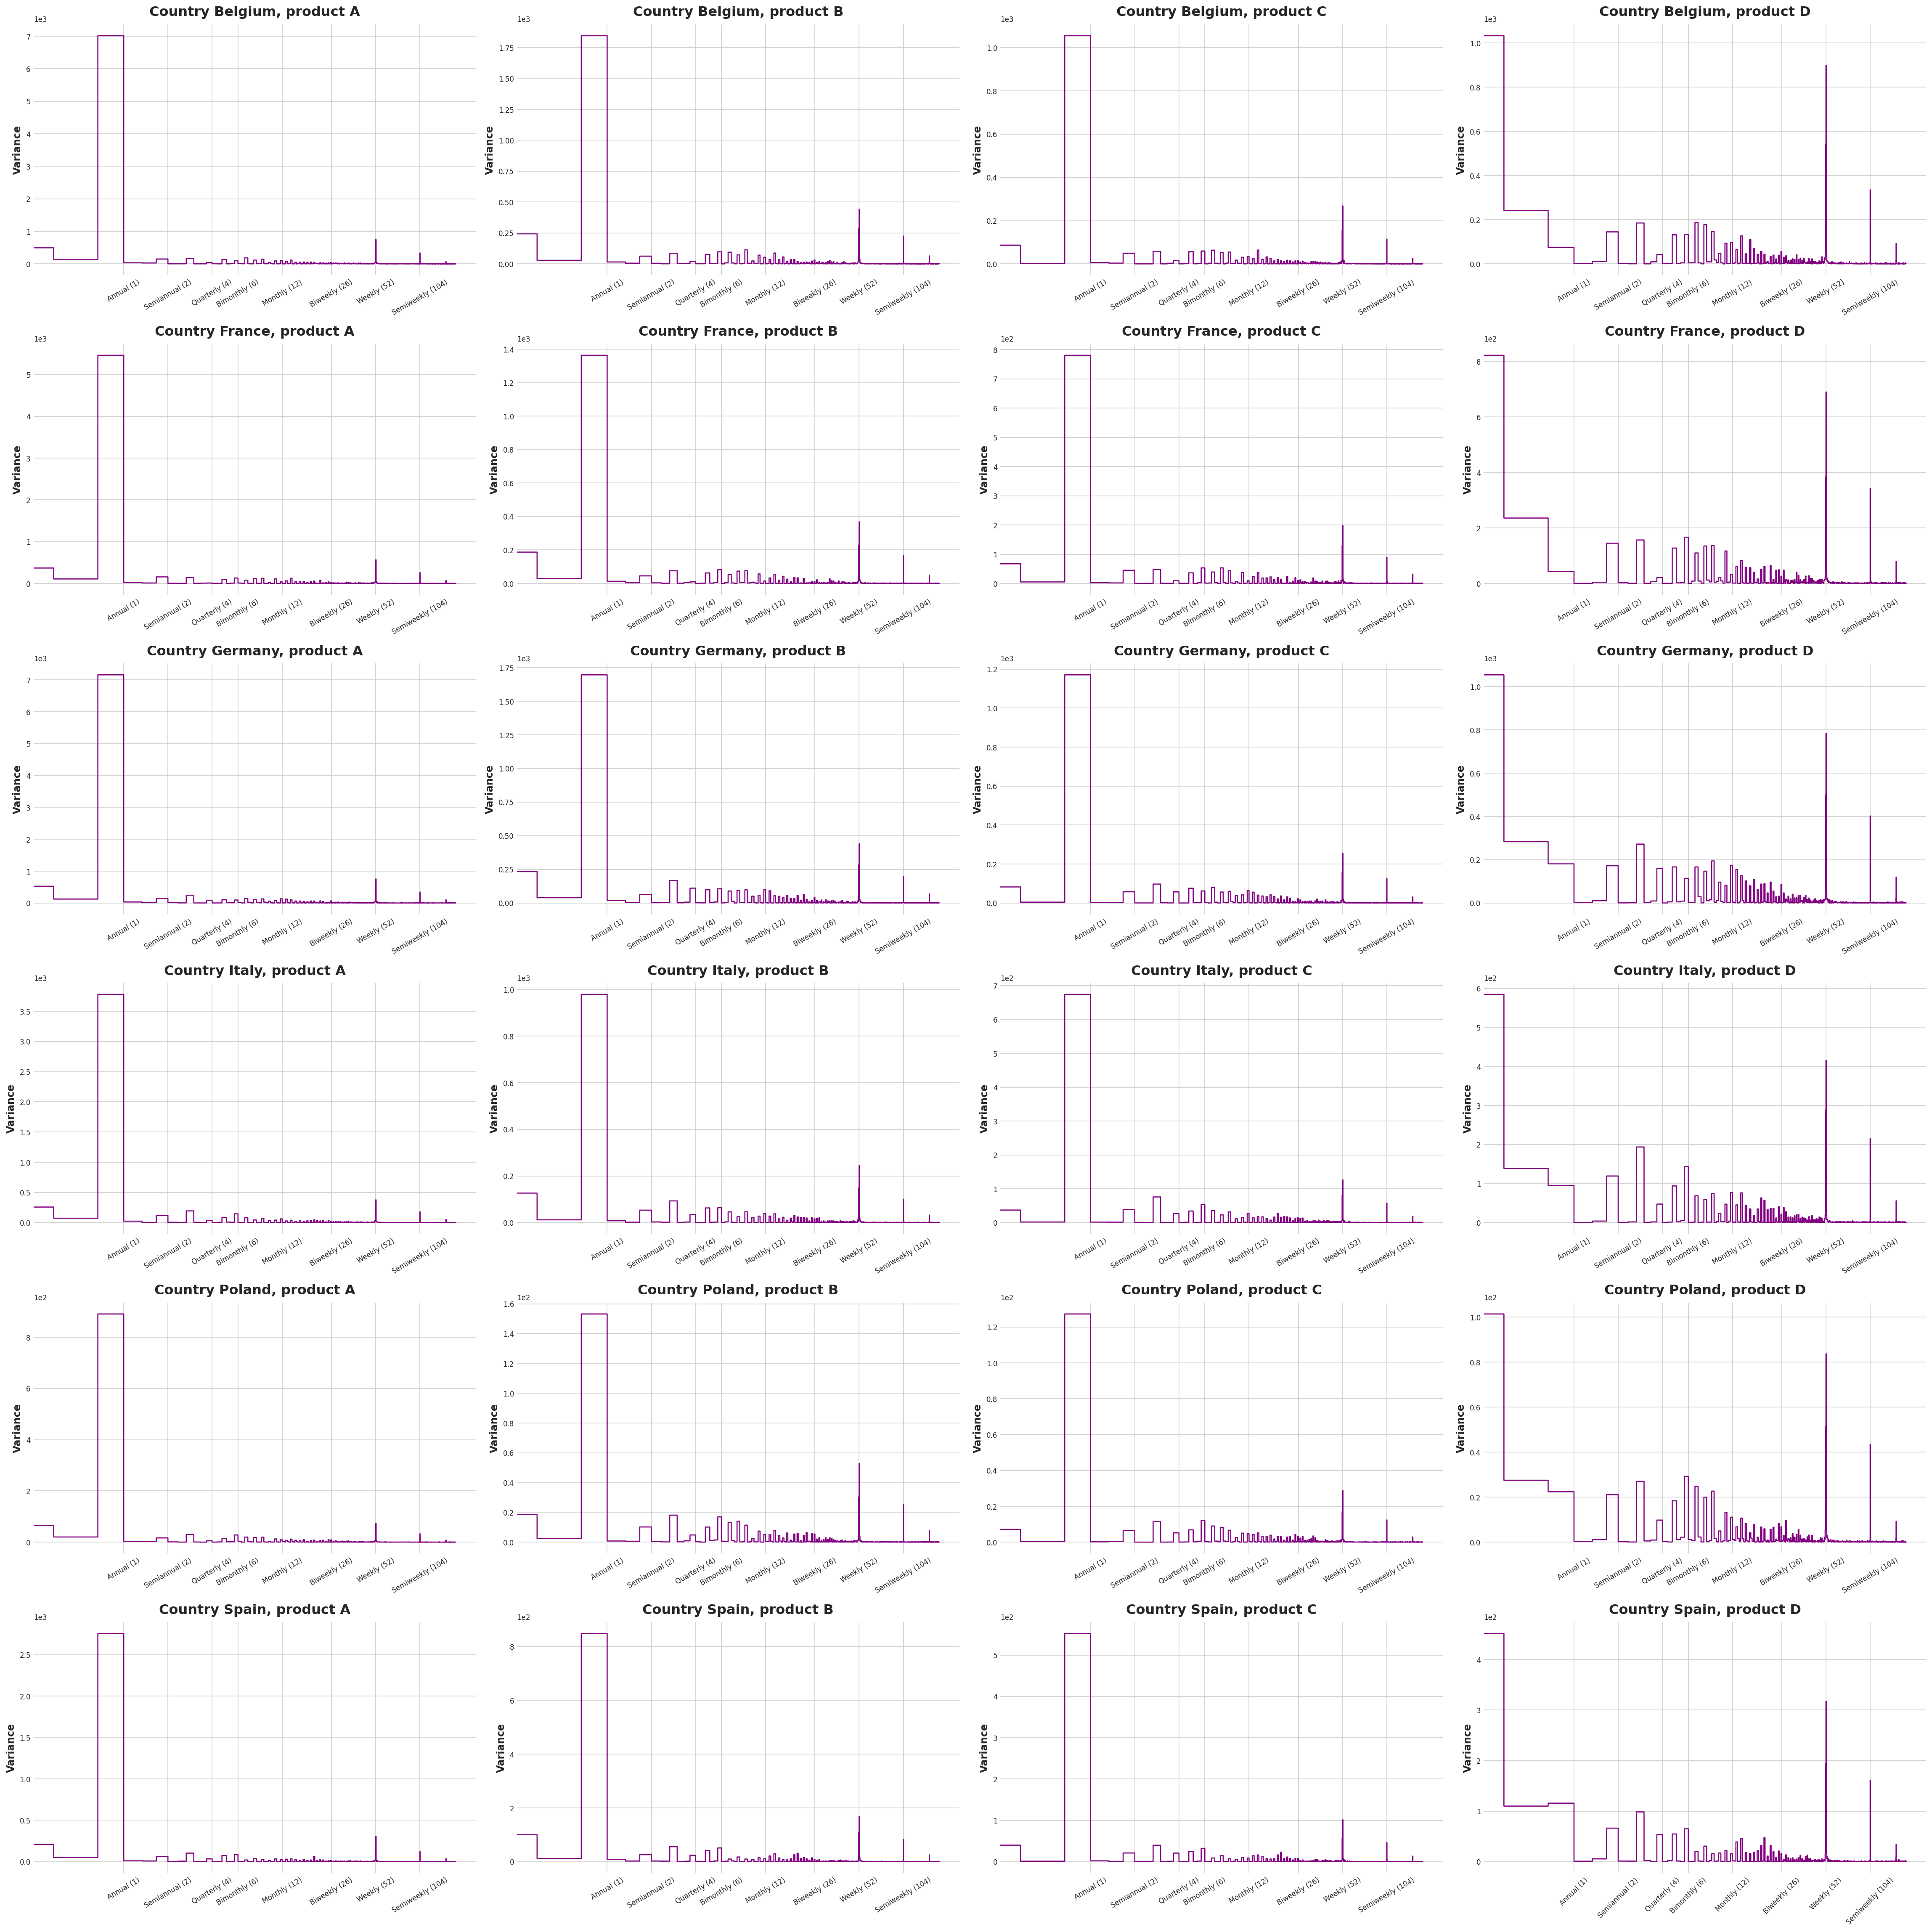

In [42]:
_, axs = plt.subplots(6,4, figsize=(32,32))

for x, ax in zip(product(countries, prods), axs.ravel()):
    tmp_df = train[(train['country'] == x[0])].groupby(['date','product']).sum().unstack(1).loc[:'2020-01-01','num_sold']
    plot_periodogram(tmp_df[x[1]], ax=ax)
    ax.set_title('Country {c}, product {p}'.format(c=x[0], p=x[1]))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  """


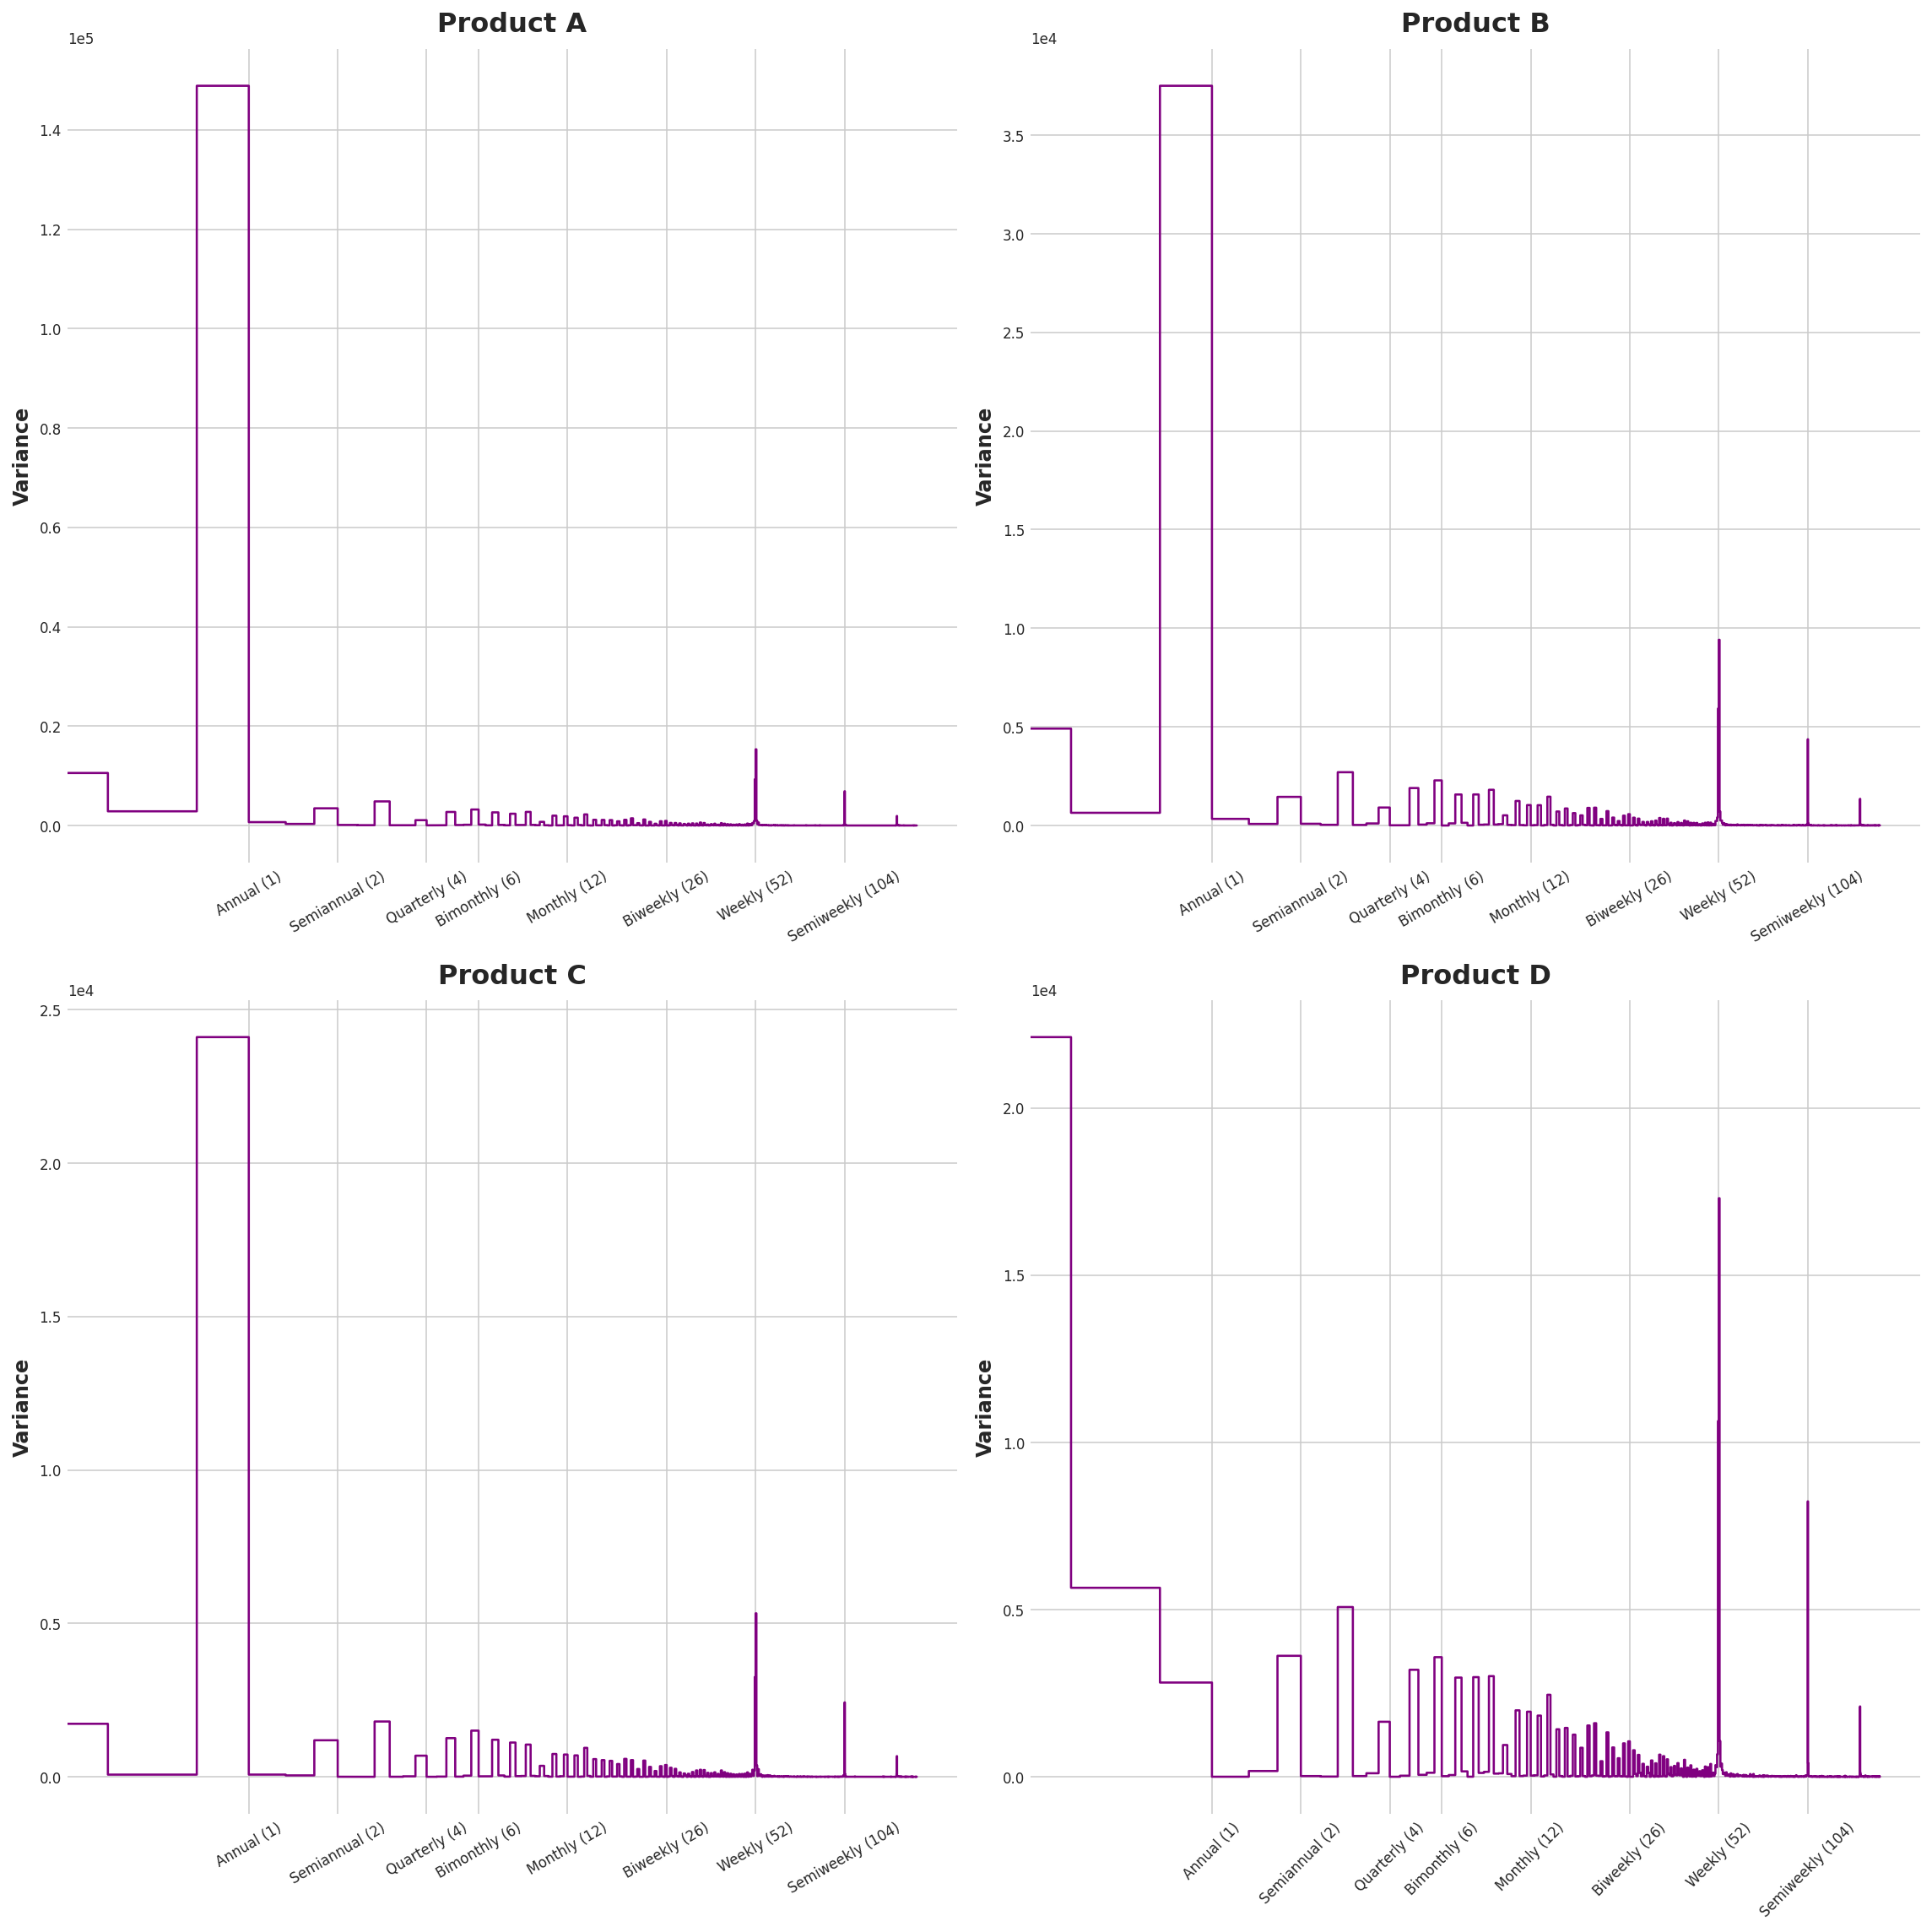

In [43]:
_, axs = plt.subplots(2,2, figsize=(16,16))

for x, ax in zip(prods, axs.ravel()):
    tmp_df = train.groupby(['date','product']).sum().unstack(1).loc[:'2020-01-01','num_sold']
    plot_periodogram(tmp_df[x], ax=ax)
    ax.set_title('Product {p}'.format(p=x))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

### Seasonality Analysis

#### Sample pre-2020

In [44]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')]
train_tot['weekday'] = train_tot['date'].apply(lambda x: x.weekday())
train_tot['month'] = train_tot['date'].apply(lambda x: x.month)
train_tot['year'] = train_tot['date'].apply(lambda x: x.year)

train_tot = train_tot.set_index('date').asfreq('D')

#### Sample second half of 2020

<AxesSubplot:xlabel='date'>

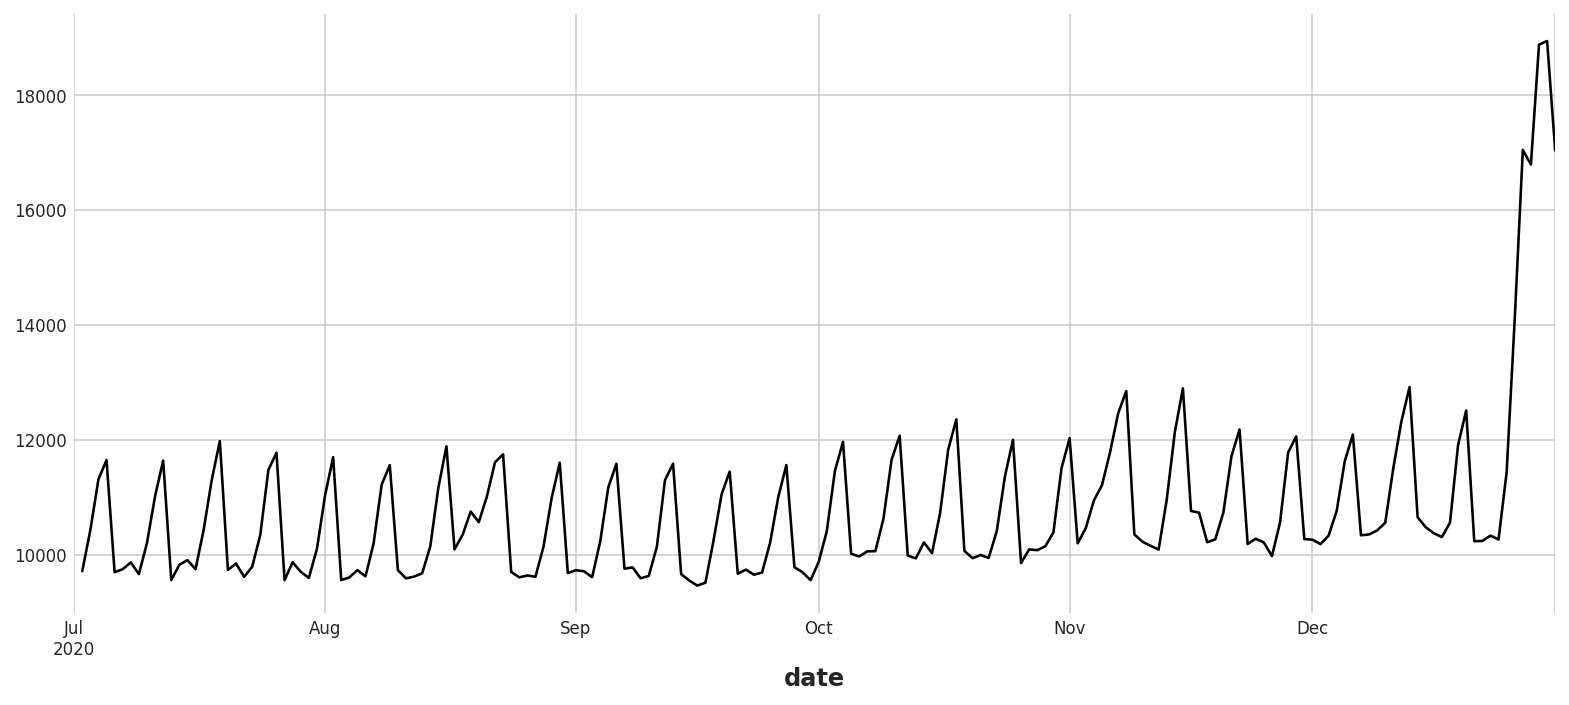

In [45]:
train_tot.loc['2020-07-01':,'num_sold'].plot()

<AxesSubplot:xlabel='date'>

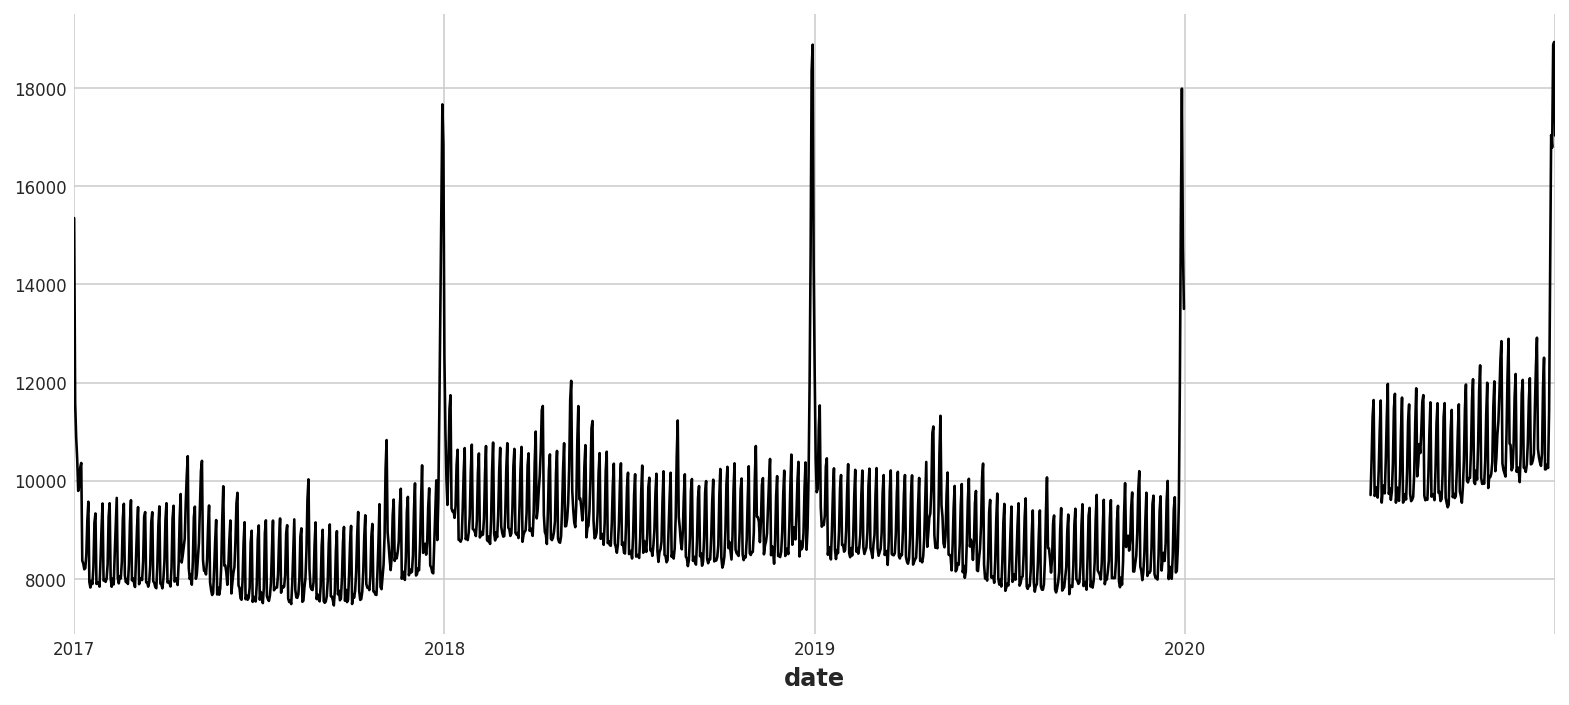

In [46]:
train_tot['num_sold'].plot()

In [47]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot = train_tot.set_index('date').asfreq('D')

In [48]:
train_tot.loc['2020-01-01':'2020-07-01','num_sold'] = np.nan

## Modelling 

* SARIMA
* Regression
 * Create day of the week and months features to capture seasonality
 * Add Fourier pairs

In [49]:
def createPairs(idx,df):
    fourier = CalendarFourier(freq="2A", order=2)  # 2 sin/cos pairs

    dp = DeterministicProcess(
                index=train_tot.set_index('date').asfreq('D').index,
                constant=False,               # dummy feature for bias (y-intercept)
                order=0,                     # trend (order 1 means linear)
                seasonal=False,               # weekly seasonality (indicators)
                additional_terms=[fourier],  # annual seasonality (fourier)
                drop=True                    # drop terms to avoid collinearity
            )

    X0 = dp.in_sample().rename(columns={'sin(1,freq=2A-DEC)':'pair1','cos(1,freq=2A-DEC)':'pair2','sin(2,freq=2A-DEC)':'pair3','cos(2,freq=2A-DEC)':'pair4'})
    df = df.join(X0, on='date', how='left')
    
    return df

### Feature engineering

In [50]:
test

row_id       date  country       store product
0       70128 2021-01-01  Belgium  KaggleMart       A
1       70129 2021-01-01  Belgium  KaggleMart       B
2       70130 2021-01-01  Belgium  KaggleMart       C
3       70131 2021-01-01  Belgium  KaggleMart       D
4       70132 2021-01-01  Belgium  KaggleRama       A
...       ...        ...      ...         ...     ...
17515   87643 2021-12-31    Spain  KaggleMart       D
17516   87644 2021-12-31    Spain  KaggleRama       A
17517   87645 2021-12-31    Spain  KaggleRama       B
17518   87646 2021-12-31    Spain  KaggleRama       C
17519   87647 2021-12-31    Spain  KaggleRama       D

[17520 rows x 5 columns]

In [51]:
train['weekday'] = train['date'].apply(lambda x: x.weekday())
train['month'] = train['date'].apply(lambda x: x.month)

test['weekday'] = test['date'].apply(lambda x: x.weekday())
test['month'] = test['date'].apply(lambda x: x.month)

### SARIMA approach

This was my first approach when looking at the data. The rationale being that:
* Data is time series
* We identified seasonality
* As it is the data is clearly not stationary so we need to differentiate at least by order 1

The conclusion after running this approach is that is does not perform very well in terms of SMAPE score.

In [52]:
# import statsmodels.api as sm
# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(y, model='additive', period = 30)
# fig = decomposition.plot()
# plt.show()

In [53]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 30
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

16


In [54]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['params', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

def SARIMA_forecast(df):
    result_df = optimize_SARIMA(parameters_list, 1, 0, 30,df['num_sold'])
    p = result_df['params'].iloc[0]
    mod = SARIMAX(df['num_sold'],order=(p[0], 1, p[1]),
                seasonal_order=(p[2], 1, p[3], 30),
                enforce_stationarity=False,
                enforce_invertibility=False)
    res = mod.fit(disp=False)
    pred = res.get_forecast(steps = 365)
    
    return pred.predicted_mean, p

In [55]:
if False: ### Toggle to avoid running as it's very long

    for x in product(countries, stores, prods):
        df = train[(train['country'] == x[0]) & (train['store'] == x[1]) & (train['product'] == x[2])]
        df = df.set_index('date').asfreq('D')

        pred, p = SARIMA_forecast(df)
        print('Combinations ({c}, {s}, {p}), optimal SARIMA params {params}'.format(c=x[0], s=x[1], p=x[2], params=p))

        new_index = test[(test['country'] == x[0]) & (test['store'] == x[1]) & (test['product'] == x[2])].index
        pred = pd.DataFrame(pred).set_index(new_index)

        if 'predicted_mean' in test.columns:
            test.loc[new_index,'predicted_mean'] = pred.loc[new_index,'predicted_mean']
        else:
            test = test.join(pred, how='left')
            
    test[['row_id','predicted_mean']].rename(columns={'predicted_mean':'num_sold'}).set_index('row_id').to_csv('submission.csv')

### Regression approach

As done in other notebooks, we will predict total sales. Assign an equal number of sales to each country. Then we will use regression models to predict the share of each product in a given country's sales. Finally, we will split product's sales between KaggleRama and KaggleMart using the more or less constant ratio observed.

Note post run: approach using SARIMA to forecast total sales does not seem to perform well. Also creating the exogeneous data set using CalendarFourier and DeterministicPRocess does not improve the score. Maybe better to use the weekday and month categorical variables I have createed + one hot encoding.

#### V1

In [56]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')].set_index('date').asfreq('D')

In [57]:
pred, p = SARIMA_forecast(train_tot)

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [58]:
pred = pd.DataFrame(pred)

for c in countries:
    pred[c] = pred['predicted_mean'] / 6.0

In [59]:
### Reusing code from Kaggle Course: https://www.kaggle.com/code/ryanholbrook/seasonality

if False:
    # train_gp = train[(train.date < '2020-01-01') | (train.date > '2020-07-01')].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']
    train_gp = train[(train.date < '2020-01-01') ].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']
    fourier = CalendarFourier(freq="A", order=2)  # 2 sin/cos pairs

    all_res = {}

    for c in countries:
        tmp_df = train_gp[c]
        tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
        all_res[c] = pd.DataFrame([], index=pred.index)
        for p in prods:
            y = tmp_df[[p]]

            dp = DeterministicProcess(
                index=y.index,
                constant=True,               # dummy feature for bias (y-intercept)
                order=1,                     # trend (order 1 means linear)
                seasonal=True,               # weekly seasonality (indicators)
                additional_terms=[fourier],  # annual seasonality (fourier)
                drop=True                    # drop terms to avoid collinearity
            )
            X = dp.in_sample()
            mod = sm.OLS(y,X)
            res = mod.fit()

            dp2 = DeterministicProcess(
                index=pred.index,
                constant=True,               # dummy feature for bias (y-intercept)
                order=1,                     # trend (order 1 means linear)
                seasonal=True,               # weekly seasonality (indicators)
                additional_terms=[fourier],  # annual seasonality (fourier)
                drop=True                    # drop terms to avoid collinearity
            )
            X_test = dp2.in_sample()
            all_res[c][p] = res.predict(X_test)


In [60]:
if False:
    for key in all_res.keys():
        all_res[key] = all_res[key].mul(pred[key],axis=0)

    ratios = {'KaggleMart':0.7424903876815521, 'KaggleRama': 1 - 0.7424903876815521}

    test['num_sold'] = 0

    for i in range(test.shape[0]):
        test['num_sold'].iloc[i] = all_res[test['country'].iloc[i]][test['product'].iloc[i]].loc[test['date'].iloc[i]] * ratios[test['store'].iloc[i]]

    test[['row_id', 'num_sold']].set_index('row_id').to_csv('submission.csv')

#### V2

Let's try a few different regression models to forecast total sales. Keep the equi-weighted split by county approach then experiment with a few other regression models for the share of product sales by country. Finally the ratio approach also stays the same for now.

In [61]:
# ### Still want to generate some Fourier pairs
# fourier = CalendarFourier(freq="2A", order=4)  # 2 sin/cos pairs

# dp = DeterministicProcess(
#             index=train_tot.set_index('date').asfreq('D').index,
#             constant=False,               # dummy feature for bias (y-intercept)
#             order=0,                     # trend (order 1 means linear)
#             seasonal=False,               # weekly seasonality (indicators)
#             additional_terms=[fourier],  # annual seasonality (fourier)
#             drop=True                    # drop terms to avoid collinearity
#         )

# X0 = dp.in_sample().rename(columns={'sin(1,freq=2A-DEC)':'pair1','cos(1,freq=2A-DEC)':'pair2','sin(2,freq=2A-DEC)':'pair3','cos(2,freq=2A-DEC)':'pair4'})
# train_tot = train_tot.join(X0, on='date', how='left')

In [62]:
# train_tot = train.groupby('date').sum()
# train_tot = train_tot.reset_index()
# train_tot['weekday'] = train_tot['date'].apply(lambda x: x.weekday())
# train_tot['month'] = train_tot['date'].apply(lambda x: x.month)
# train_tot['year'] = train_tot['date'].apply(lambda x: x.year)
# train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')]

In [63]:
# X = train_tot[["weekday", "month", "year"]]
# y = train_tot["num_sold"]

# categorical_features = ["weekday", "month", "year"]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
# )

# kf = KFold(n_splits=3)

# for train_index, test_index in kf.split(X):
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#     X_test, y_test = X.iloc[test_index], y.iloc[test_index]

#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print("model MSE: %.3f" % mean_squared_error(y_pred, y_test))  # using MSE to penalize large errors

In [64]:
# y.plot()

In [65]:
# X = train_tot[["weekday", "month", "year","pair1", "pair2", "pair3", "pair4"]]
# y = train_tot["num_sold"]

# categorical_features = ["weekday", "month", "year"]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor), ("classifier", SVR())]
# )

# kf = KFold(n_splits=3)
# for train_index, test_index in kf.split(X):
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#     X_test, y_test = X.iloc[test_index], y.iloc[test_index]

#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print("model MSE: %.3f" % mean_squared_error(y_pred, y_test)) # using MSE to penalize large errors

In [66]:
# X = train_tot[["weekday", "month", "year","pair1", "pair2", "pair3", "pair4"]]
# y = train_tot["num_sold"]

# categorical_features = ["weekday", "month", "year"]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor), ("classifier", Ridge())]
# )

# kf = KFold(n_splits=3)
# for train_index, test_index in kf.split(X):
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#     X_test, y_test = X.iloc[test_index], y.iloc[test_index]

#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print("model MSE: %.3f" % mean_squared_error(y_pred, y_test)) # using MSE to penalize large errors

In [67]:
# X = train_tot[["weekday", "month", "year"]]
# y = train_tot["num_sold"]

# categorical_features = ["weekday", "month", "year"]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor), ("classifier", Ridge())]
# )

# kf = KFold(n_splits=3)
# for train_index, test_index in kf.split(X):
#     X_train, y_train = X.iloc[train_index], y.iloc[train_index]
#     X_test, y_test = X.iloc[test_index], y.iloc[test_index]

#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print("model MSE: %.3f" % mean_squared_error(y_pred, y_test)) # using MSE to penalize large errors

In [68]:
# test_tot = test.groupby('date').sum()
# test_tot = test_tot.reset_index()
# test_tot['weekday'] = test_tot['date'].apply(lambda x: x.weekday())
# test_tot['month'] = test_tot['date'].apply(lambda x: x.month)
# test_tot['year'] = test_tot['date'].apply(lambda x: x.year)
# X_test = test_tot[["weekday", "month", "year"]]

In [69]:
# clf.fit(X, y)
# test_pred = clf.predict(X_test)

In [70]:
# plt.plot(test_pred)

In [71]:
# test_pred = pd.DataFrame(test_pred, columns=['total_sales'],index=test_tot.set_index('date').asfreq('D').index)

# for c in countries:
#     test_pred[c] = test_pred['total_sales'] / 6.0

Ridge regression definitely seems to have lower MSE than the two other models I experimented with (XGBoost and SVM). In addition, it seems that the Fourier pairs don't add any explanatory power (need to double check, not sure why). Ideally I would like to perform CV at some point to fine tune the Ridge hyper parameters.

#### V3

In [72]:
# train_tot = train.groupby('date').sum()
# train_tot = train_tot.reset_index()
# train_tot = train_tot.set_index('date').asfreq('D')

# train_tot.loc['2020-01-01':'2020-07-01','num_sold'] = np.nan

# # create a series with holes:
# series_holes = TimeSeries.from_times_and_values(train_tot.index, train_tot['num_sold'])
# series_holes.plot()

# kernel = RBF()

# gpf = GaussianProcessFilter(kernel=kernel, alpha=0.1, normalize_y=True)
# filtered_series = gpf.filter(series_holes, num_samples=100)

In [73]:
# filtered_series.plot()

In [74]:
# filtered_series[8].pd_dataframe()

In [75]:
# train_gp = train[(train.date < '2020-01-01') ].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']

# all_res = {}

# for c in countries:
#     tmp_df = train_gp[c]
#     tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
#     all_res[c] = pd.DataFrame([], index=test_pred.index)
#     for p in prods:
#         X = tmp_df[[p]]
#         y = tmp_df[[p]]
        
#         X = X.reset_index()
#         X['weekday'] = X['date'].apply(lambda x: x.weekday())
#         X['month'] = X['date'].apply(lambda x: x.month)
#         X['year'] = X['date'].apply(lambda x: x.year)
#         X = X.set_index('date').asfreq('D')
#         X = X[["weekday", "month", "year"]]
#         X = createPairs(X.index, X)
        
#         categorical_features = ["weekday", "month", "year"]
#         categorical_transformer = OneHotEncoder(handle_unknown="ignore")

#         preprocessor = ColumnTransformer(
#             transformers=[
#                 ("cat", categorical_transformer, categorical_features),
#             ]
#         )

#         clf = Pipeline(
#             steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
#         )

#         clf.fit(X, y)
        
#         X_test = test_pred.reset_index()
#         X_test['weekday'] = X_test['date'].apply(lambda x: x.weekday())
#         X_test['month'] = X_test['date'].apply(lambda x: x.month)
#         X_test['year'] = X_test['date'].apply(lambda x: x.year)
#         X_test = X_test.set_index('date').asfreq('D')
#         X_test = X_test[["weekday", "month", "year"]]
        
#         X_test = createPairs(X_test.index, X_test)
#         all_res[c][p] = clf.predict(X_test)


In [76]:
# for key in all_res.keys():
#     all_res[key] = all_res[key].mul(test_pred[key],axis=0)

# ratios = {'KaggleMart':0.7424903876815521, 'KaggleRama': 1 - 0.7424903876815521}

# test['num_sold'] = 0

# for i in range(test.shape[0]):
#     test['num_sold'].iloc[i] = all_res[test['country'].iloc[i]][test['product'].iloc[i]].loc[test['date'].iloc[i]] * ratios[test['store'].iloc[i]]
    
# test[['row_id', 'num_sold']].to_csv('submission.csv', index=False)

## Testing KATS

In [77]:
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams


### No rescaling

Prophet seems to pick up the different seasonality components pretty well from a look at the forecasted time series. However, without rescaling the data, the jump in total sales between 2019 and mid-2020 leads the model to infer a large positive trend. 2021 forecasts will then reflect that inflated positive trend.

In [78]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()

train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')].set_index('date').asfreq('D')

In [79]:
ts = TimeSeriesData(train_tot[['num_sold']].reset_index(), time_col_name='date')

In [80]:
# Specify parameters
params = ProphetParams(seasonality_mode="additive")

# Create a model instance
m = ProphetModel(ts, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=365, freq="D")
fcst

Initial log joint probability = -90.437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3627.69     0.0012298       93.8772      0.3264      0.3264      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       3629.18   4.30453e-05       79.4532   5.079e-07       0.001      284  LS failed, Hessian reset 
     199        3629.2   5.75806e-05       82.0951      0.2099      0.8307      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234        3629.4   0.000365819       215.802   4.347e-06       0.001      405  LS failed, Hessian reset 
     270       3629.45   3.63435e-07       39.9934   8.595e-09       0.001      494  LS failed, Hessian reset 
     274       3629.45    1.2605e-07       38.9002      0.5537      0.5537      499   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

time          fcst    fcst_lower    fcst_upper
0   2021-01-01  14155.865798  13401.621307  15003.599334
1   2021-01-02  15048.961653  14243.780154  15874.475729
2   2021-01-03  15466.056318  14604.979123  16310.726709
3   2021-01-04  13639.751840  12804.399737  14438.987800
4   2021-01-05  13537.901915  12693.649797  14352.236502
..         ...           ...           ...           ...
360 2021-12-27  15552.131511  14498.656469  16550.532139
361 2021-12-28  15663.977610  14724.683157  16731.736926
362 2021-12-29  15743.018579  14683.813381  16713.860313
363 2021-12-30  15818.489003  14845.341298  16836.874779
364 2021-12-31  16320.273024  15308.458634  17258.507243

[365 rows x 4 columns]

<AxesSubplot:>

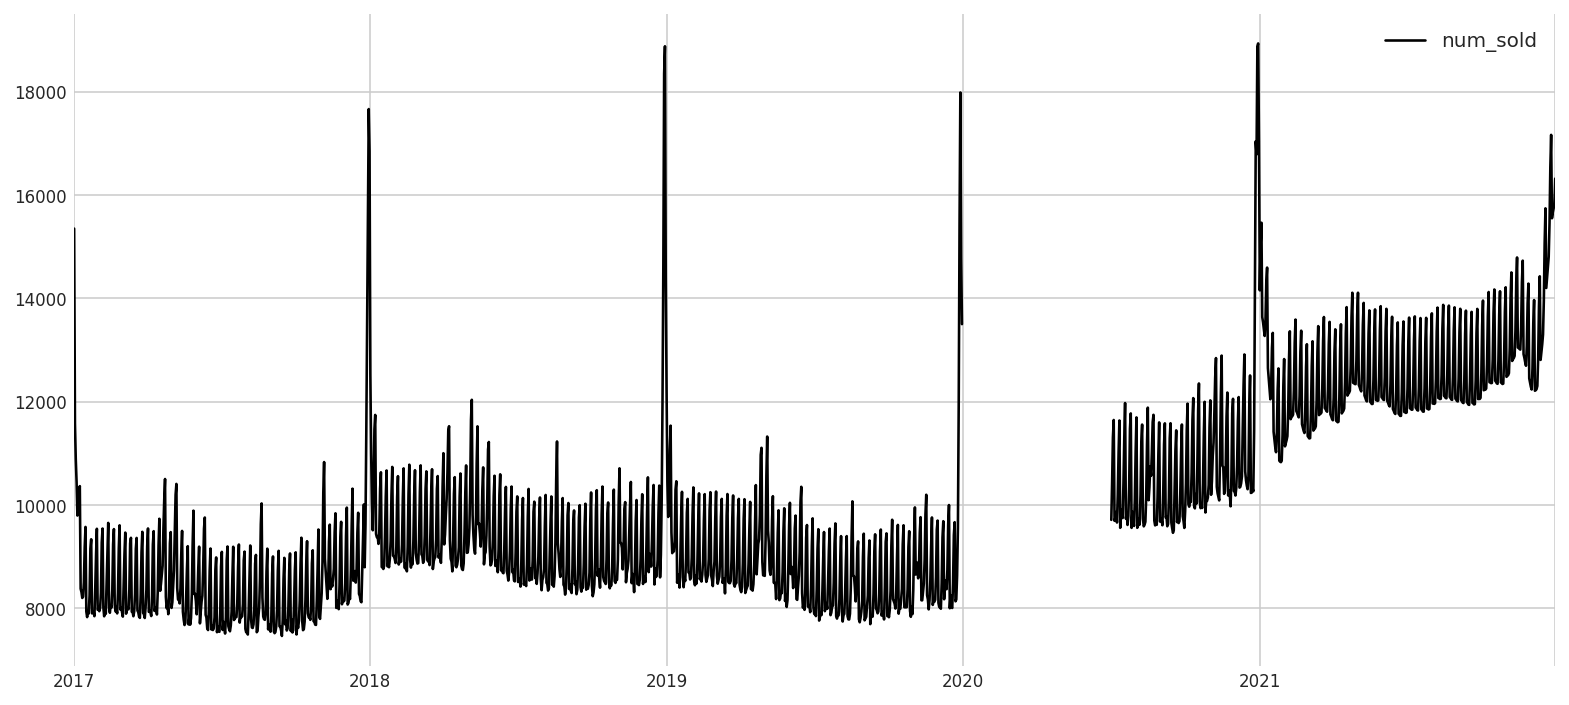

In [81]:
fcst = fcst.set_index('time').asfreq('D')
full_df = pd.concat([train_tot[['num_sold']],fcst[['fcst']].rename(columns={'fcst':'num_sold'})], axis=0)
full_df.plot()

### Rescaling

Dramatic change in total sales between end of 2019 and end of 2020 could affect forecast. In fact, KATS infers a trend leading to too high forecasts of 2021 sales.

In [82]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot['weekday'] = train_tot['date'].apply(lambda x: x.weekday())
train_tot['month'] = train_tot['date'].apply(lambda x: x.month)
train_tot['year'] = train_tot['date'].apply(lambda x: x.year)
train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')].set_index('date').asfreq('D')

In [83]:
yearly_ratios = train_tot.groupby('year').mean()['num_sold']
yearly_ratios = yearly_ratios.div(yearly_ratios.loc[2020.0])
train_tot['num_sold'] = train_tot.dropna().apply(lambda x: x.num_sold / yearly_ratios.loc[x.year],axis=1)

In [84]:
ts = TimeSeriesData(train_tot[['num_sold']].reset_index(), time_col_name='date')

In [85]:
# Specify parameters
params = ProphetParams(seasonality_mode="additive")

# Create a model instance
m = ProphetModel(ts, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=365, freq="D")
fcst

Initial log joint probability = -77.9791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3655.44    0.00213333       397.231           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3657.64    0.00125577       134.949           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       3658.07   0.000250616       171.785   2.264e-06       0.001      323  LS failed, Hessian reset 
     299       3658.21   5.54686e-07       63.5454           1           1      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       3658.21   7.69833e-06       77.8538   1.089e-07       0.001      465  LS failed, Hessian reset 
     320       3658.21   8.88395e-08       72.8166      0.1726           1      482   
Optimization terminat

time          fcst    fcst_lower    fcst_upper
0   2021-01-01  14201.098236  13241.684074  15122.331671
1   2021-01-02  15221.083880  14227.051215  16279.525855
2   2021-01-03  15681.684580  14655.715539  16677.273363
3   2021-01-04  13499.259577  12510.966361  14513.136237
4   2021-01-05  13354.905675  12346.953473  14399.981345
..         ...           ...           ...           ...
360 2021-12-27  13644.222310  12630.278338  14625.465507
361 2021-12-28  13752.771249  12650.029902  14798.310669
362 2021-12-29  13816.450862  12911.357531  14820.597533
363 2021-12-30  13879.458835  12887.446996  14833.743645
364 2021-12-31  14442.389516  13455.530953  15440.742445

[365 rows x 4 columns]

<AxesSubplot:>

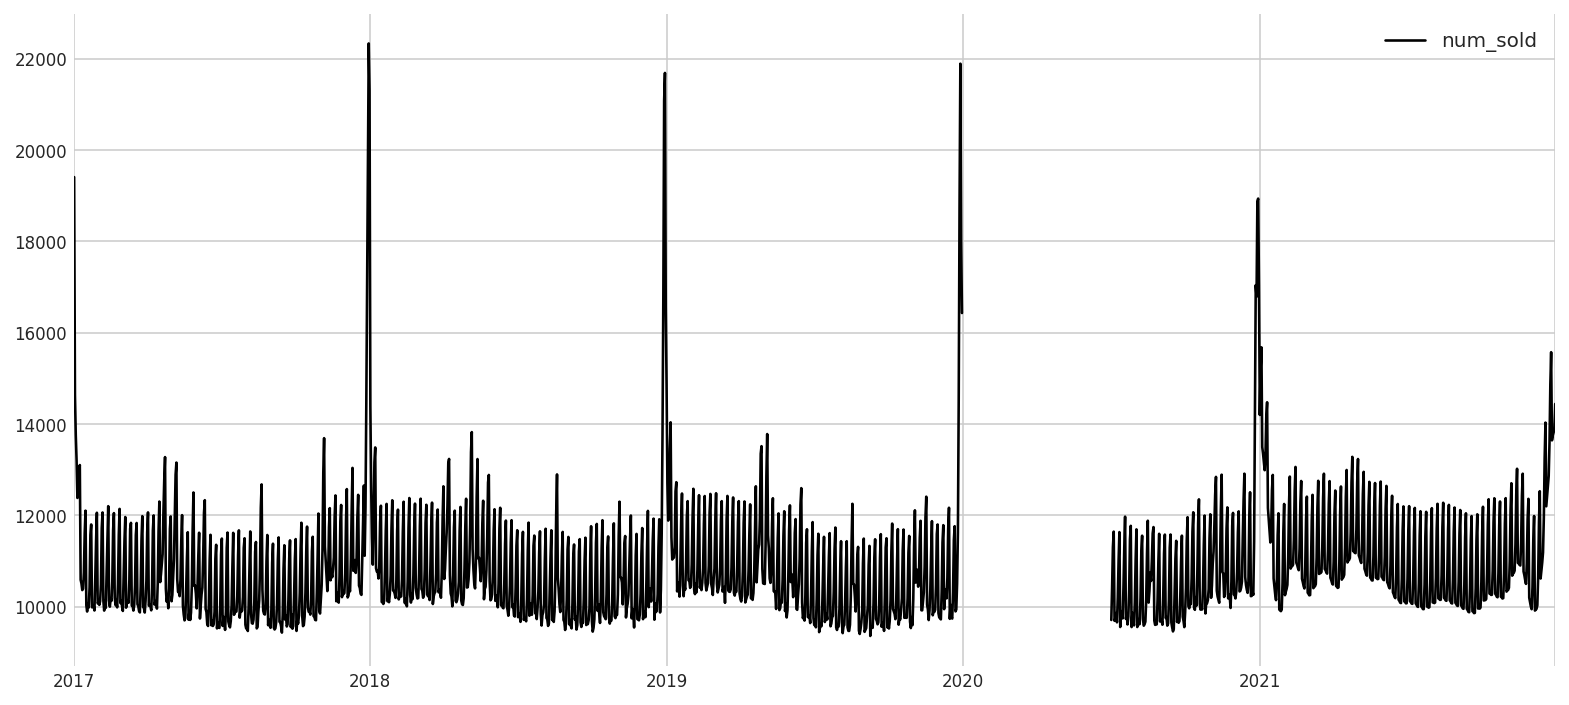

In [86]:
fcst = fcst.set_index('time').asfreq('D')
full_df = pd.concat([train_tot[['num_sold']],fcst[['fcst']].rename(columns={'fcst':'num_sold'})], axis=0)
full_df.plot()

In [87]:
test_pred = fcst[['fcst']]

for c in countries:
    test_pred[c] = test_pred['fcst'] / 6.0

test_pred = test_pred.reset_index()
test_pred = test_pred.rename(columns={'time':'date','fcst':'total_sales'})
test_pred = test_pred.set_index('date')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
test_tot = test.groupby('date').sum()
test_tot = test_tot.reset_index()
test_tot['weekday'] = test_tot['date'].apply(lambda x: x.weekday())
test_tot['month'] = test_tot['date'].apply(lambda x: x.month)
test_tot['year'] = test_tot['date'].apply(lambda x: x.year)

X_test = test_tot[["weekday", "month", "year"]]

In [89]:
#Important dates, these day of year have extra info, weekends, holiday shopping, etc
# important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,16,17, 124, 125, 126, 127, 140, 141,142, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
# train_gp = train[(train.date < '2020-01-01') ].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']

# all_res = {}

# for c in countries:
#     tmp_df = train_gp[c]
#     tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
#     all_res[c] = pd.DataFrame([], index=test_pred.index)
#     for p in prods:
#         X = tmp_df[[p]]
#         y = tmp_df[[p]]
        
#         X = X.reset_index()
#         X['weekday'] = X['date'].apply(lambda x: x.weekday())
#         X['month'] = X['date'].apply(lambda x: x.month)
#         X['year'] = X['date'].apply(lambda x: x.year)
        
#         X['weekday'] = X['date'].apply(lambda x: x.weekday())
#         X["day_of_week"] = X["date"].dt.dayofweek
#         X["day_of_week"] = X["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))

#         X['month'] = X['date'].apply(lambda x: x.month)
#         X["month_sin"] = np.sin(X['month'] * (2 * np.pi / 12))
#         X['year'] = X['date'].apply(lambda x: x.year)

#         X["day_of_year"] = X["date"].dt.dayofyear
#         #account for leap year
#         X["day_of_year"] = X.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
#         X["important_dates"] = X["day_of_year"].apply(lambda x: x if x in important_dates else 0)

#         X = X.set_index('date').asfreq('D')
#         X = X[["day_of_week", "month_sin", "month", "day_of_year", "year", "important_dates"]]
# #         X = createPairs(X.index, X)
        
#         categorical_features = ["month", "year"]
#         categorical_transformer = OneHotEncoder(handle_unknown="ignore")

#         preprocessor = ColumnTransformer(
#             transformers=[
#                 ("cat", categorical_transformer, categorical_features),
#             ]
#         )

#         clf = Pipeline(
#             steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
#         )

#         clf.fit(X, y)
        
#         X_test = test_pred.reset_index()
#         X_test["day_of_week"] = X_test["date"].dt.dayofweek
#         X_test["day_of_week"] = X_test["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))

#         X_test['month'] = X_test['date'].apply(lambda x: x.month)
#         X_test["month_sin"] = np.sin(X_test['month'] * (2 * np.pi / 12))
#         X_test['year'] = X_test['date'].apply(lambda x: x.year)

#         X_test["day_of_year"] = X_test["date"].dt.dayofyear
#         #account for leap year
#         X_test["day_of_year"] = X_test.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
#         X_test["important_dates"] = X_test["day_of_year"].apply(lambda x: x if x in important_dates else 0)
#         X_test = X_test.set_index('date').asfreq('D')
#         X_test = X_test[["day_of_week", "month_sin", "month", "day_of_year", "year", "important_dates"]]

#         all_res[c][p] = clf.predict(X_test)


In [90]:
#Important dates, these day of year have extra info, weekends, holiday shopping, etc
important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,16,17, 124, 125, 126, 127, 140, 141,142, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
train_gp = train[(train.date < '2020-01-01') ].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']

all_res = {}

for c in countries:
    tmp_df = train_gp[c]
    tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
    all_res[c] = pd.DataFrame([], index=test_pred.index)
    for p in prods:
        X = tmp_df[[p]]
        y = tmp_df[[p]]
        
        X = X.reset_index()
        X['weekday'] = X['date'].apply(lambda x: x.weekday())
        X['month'] = X['date'].apply(lambda x: x.month)
        X['year'] = X['date'].apply(lambda x: x.year)
        
        X['weekday'] = X['date'].apply(lambda x: x.weekday())
        X["day_of_week"] = X["date"].dt.dayofweek
        X["day_of_week"] = X["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))

        X['month'] = X['date'].apply(lambda x: x.month)
        X["month_sin"] = np.sin(X['month'] * (2 * np.pi / 12))
        X['year'] = X['date'].apply(lambda x: x.year)

        X["day_of_year"] = X["date"].dt.dayofyear
        #account for leap year
        X["day_of_year"] = X.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
        X["important_dates"] = X["day_of_year"].apply(lambda x: x if x in important_dates else 0)

        X = X.set_index('date').asfreq('D')
        X = X[["day_of_week", "month_sin", "month", "day_of_year", "year", "important_dates"]]
#         X = createPairs(X.index, X)
        
        categorical_features = ["month", "year"]
        categorical_transformer = OneHotEncoder(handle_unknown="ignore")

        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", categorical_transformer, categorical_features),
            ]
        )

        clf = Pipeline(
            steps=[("preprocessor", preprocessor), ("classifier", Lasso(tol=0.00001,max_iter=10000,alpha=0.1))]
        )

        clf.fit(X, y)
        
        X_test = test_pred.reset_index()
        X_test["day_of_week"] = X_test["date"].dt.dayofweek
        X_test["day_of_week"] = X_test["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))

        X_test['month'] = X_test['date'].apply(lambda x: x.month)
        X_test["month_sin"] = np.sin(X_test['month'] * (2 * np.pi / 12))
        X_test['year'] = X_test['date'].apply(lambda x: x.year)

        X_test["day_of_year"] = X_test["date"].dt.dayofyear
        #account for leap year
        X_test["day_of_year"] = X_test.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
        X_test["important_dates"] = X_test["day_of_year"].apply(lambda x: x if x in important_dates else 0)
        X_test = X_test.set_index('date').asfreq('D')
        X_test = X_test[["day_of_week", "month_sin", "month", "day_of_year", "year", "important_dates"]]

        all_res[c][p] = clf.predict(X_test)


In [91]:
for key in all_res.keys():
    all_res[key] = all_res[key].mul(test_pred[key],axis=0)

ratios = {'KaggleMart':0.7424903876815521, 'KaggleRama': 1 - 0.7424903876815521}

test['num_sold'] = 0

for i in range(test.shape[0]):
    test['num_sold'].iloc[i] = all_res[test['country'].iloc[i]][test['product'].iloc[i]].loc[test['date'].iloc[i]] * ratios[test['store'].iloc[i]]
    
test[['row_id', 'num_sold']].to_csv('submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Attempt at fitting an LSTM NN

In [92]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot['weekday'] = train_tot['date'].apply(lambda x: x.weekday())
train_tot['month'] = train_tot['date'].apply(lambda x: x.month)
train_tot['year'] = train_tot['date'].apply(lambda x: x.year)
train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')].set_index('date').asfreq('D')

In [93]:
yearly_ratios = train_tot.groupby('year').mean()['num_sold']
yearly_ratios = yearly_ratios.div(yearly_ratios.loc[2020.0])
train_tot['num_sold'] = train_tot.dropna().apply(lambda x: x.num_sold / yearly_ratios.loc[x.year],axis=1)

<AxesSubplot:xlabel='date'>

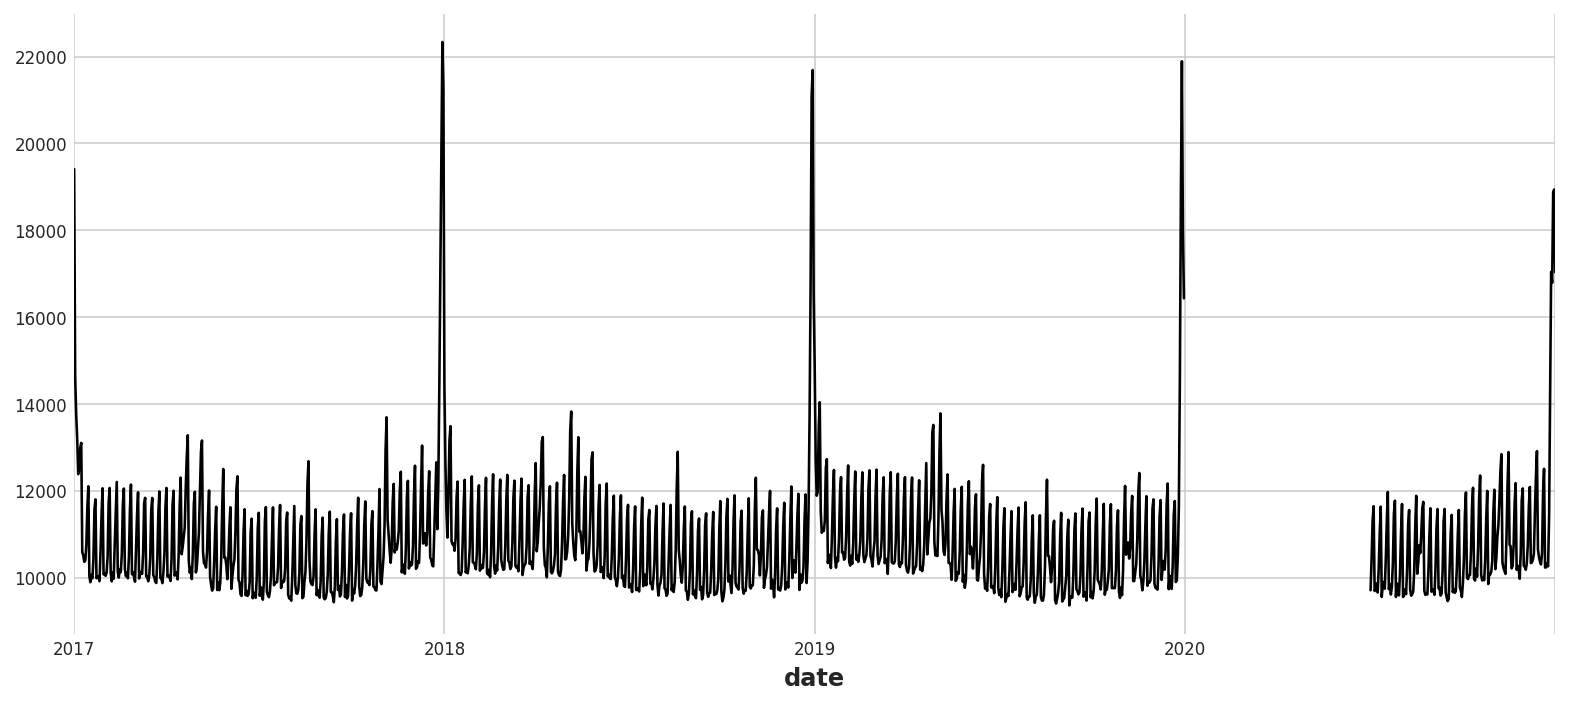

In [94]:
train_tot['num_sold'].plot()

In [95]:
# categorical_features = ["weekday", "month", "year"]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor)]
# )



# features = train_tot[["weekday", "month", "year"]]
# features = clf.fit_transform(features)

In [96]:
# split_fraction = 0.715
# train_split = int(split_fraction * int(df.shape[0]))
# step = 6

# past = 720
# future = 72
# learning_rate = 0.001
# batch_size = 256
# epochs = 10

# def normalize(data, train_split):
#     data_mean = data[:train_split].mean(axis=0)
#     data_std = data[:train_split].std(axis=0)
#     return (data - data_mean) / data_std


# features = train_tot[["weekday", "month", "year"]]
# features = normalize(features.values, train_split)
# features = pd.DataFrame(features)
# features.head()

# train_data = features.loc[0 : train_split - 1]
# val_data = features.loc[train_split:]